In [269]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import table
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols

# Table of Contents:
    
   * [1. Survey Analysis - Descriptive Stats](#survey)
   * [2. Reduced-Form Data Analysis of Experimental Results](#reduced)
   * [3. Moment Estimation](#moments)
   * [4. Figures, using estimated Moments](#figures)

---
# 1. Survey Analysis  - Descriptive Stats <a class="anchor" id="survey"></a>
---

In [3]:
### STEP 1. Analysis of Response to 2008 Survey ###
##     for Experimental Design Section    ##
survey_df = pd.read_stata(r"C:\Users\Lenovo\Downloads\charity_code_and_appendix\reduced form\regs\SurveyContent2008Short.dta")

In [4]:
## Summary stats on rank of charities
survey_df.iloc[:, 0:5].describe().iloc[[0, 1, 2, 3, -1], :].T

,count,mean,std,min,max
rank_donatelife,229.0,3.799127,1.282062,1.0,5.0
rank_chihistso,253.0,2.960474,1.240207,1.0,5.0
rank_lar,239.0,3.953975,1.160436,1.0,5.0
rank_seattle,231.0,3.467532,1.410375,1.0,5.0
rank_ecu,220.0,2.540909,1.335555,1.0,5.0


In [245]:
#fig = plt.figure(figsize = (12, 5))
#ax = fig.add_subplot(111, frame_on= True)
#sdf = survey_df.iloc[:, 0:5].describe().iloc[[0, 1, 2, 3, -1], :].T
#ax.axis("off")
#table(ax, sdf, loc = 'center')
#plt.savefig('table41.png', dpi = "figure", format = "png")

In [37]:
## Summary stats on pledge for favored charity
def tabulate(arg):
    pc = survey_df[arg].unique()
    tab = []
    for i in range(0,6):
        tab.append(len(survey_df.loc[survey_df[arg] == pc[i]]))
    dt = {"Freq.": [tab[0], tab[1], tab[2], tab[3], tab[4], tab[5]],
          "Percent": [round((tab[0] *100)/len(survey_df), 3), round((tab[1] *100)/len(survey_df), 3),
                        round((tab[2] *100)/len(survey_df), 3), round((tab[3] *100)/len(survey_df), 3), 
                        round((tab[4] *100)/len(survey_df), 3), round((tab[5] *100)/len(survey_df), 3)],
          "Cum.": [round((tab[0] *100)/len(survey_df), 3), 
                    round((tab[0] *100)/len(survey_df) + (tab[1] *100)/len(survey_df), 3), 
                    round((tab[0] *100)/len(survey_df) + (tab[1] *100)/len(survey_df) + (tab[2] *100)/len(survey_df), 3), 
                    round((tab[0] *100)/len(survey_df) + (tab[1] *100)/len(survey_df) + (tab[2] *100)/len(survey_df) + \
                    (tab[3] *100)/len(survey_df), 3), 
                    round((tab[0] *100)/len(survey_df) + (tab[1] *100)/len(survey_df) + (tab[2] *100)/len(survey_df) + \
                    (tab[3] *100)/len(survey_df) + (tab[4] *100)/len(survey_df), 3),
                    round((tab[0] *100)/len(survey_df)+(tab[1] *100)/len(survey_df)+(tab[2] *100)/len(survey_df)+\
                    (tab[3] *100)/len(survey_df)+(tab[4] *100)/len(survey_df)+ (tab[5] *100)/len(survey_df), 3)]}
    pc = ["lar", "donatelife", "ecu", "seattle", "", "chihistso"]
    df = pd.DataFrame(index = pc, data = dt)
    df.index.rename("Pledge Choice", inplace = True)
    return df


In [246]:
#tabulate("pledge_choice")

In [247]:
#fig = plt.figure(figsize = (10, 5))
#ax = fig.add_subplot(111)
#pledge = tabulate("pledge_choice")
#ax.axis("off")
#table(ax, pledge, loc = 'center')
#plt.savefig('table42.png', dpi = "figure", format = "png")

In [40]:
## Summary stats on amount given by charity type
def charity_type(list_arg):
    for i in list_arg:
        survey_df.loc[(~survey_df[f"{i}_total"].isnull()) & (survey_df[f"{i}_total"].where(survey_df[f"{i}_total"] > 0)),
                  f"{i}_pos"] = 1
        survey_df.loc[survey_df[f"{i}_total"] == 0, f"{i}_pos"] = 0
        survey_df[f"{i}_wins"] = survey_df[f"{i}_total"]
        survey_df.loc[survey_df[f"{i}_wins"]>1000, f"{i}_wins"] = 1000
    return survey_df
    
    

In [42]:
survey_df.loc[(~survey_df["dtd_pos"].isnull()) & (~survey_df["phone_pos"].isnull()) & (~survey_df["mail_pos"].isnull()) & \
              (~survey_df["personal_pos"].isnull()), "samplenomiss"] = 1
survey_df.loc[(survey_df["dtd_pos"].isnull()) | (survey_df["phone_pos"].isnull()) | (survey_df["mail_pos"].isnull()) | \
              (survey_df["personal_pos"].isnull()), "samplenomiss"] = 0

In [47]:
## Fund-raisers contacted you in the past 12 months at least X times
def tabulate_dtd(arg, index_name):
    pc = survey_df.loc[~survey_df[arg].isnull()][arg].unique()
    tab = []
    for i in range(0,5):
        tab.append(len(survey_df.loc[survey_df[arg] == pc[i]]))
    dt = {"Freq.": [tab[0], tab[1], tab[2], tab[3], tab[4]],
          "Percent": [(tab[0] *100)/len(survey_df), (tab[1] *100)/len(survey_df),
                        (tab[2] *100)/len(survey_df), (tab[3] *100)/len(survey_df), 
                        (tab[4] *100)/len(survey_df)],
          "Cum.": [(tab[0] *100)/len(survey_df), 
                    (tab[0] *100)/len(survey_df) + (tab[1] *100)/len(survey_df), 
                    (tab[0] *100)/len(survey_df) + (tab[1] *100)/len(survey_df) + (tab[2] *100)/len(survey_df), 
                    (tab[0] *100)/len(survey_df) + (tab[1] *100)/len(survey_df) + (tab[2] *100)/len(survey_df) + \
                    (tab[3] *100)/len(survey_df), 
                    (tab[0] *100)/len(survey_df) + (tab[1] *100)/len(survey_df) + (tab[2] *100)/len(survey_df) + \
                    (tab[3] *100)/len(survey_df) + (tab[4] *100)/len(survey_df)]}
    df = pd.DataFrame(index = pc, data = dt)
    df.index.rename(index_name, inplace = True)
    df = df.reset_index(level=0)
    return df

In [248]:
# Door-to-door
#tabulate_dtd("dtd_freq", "Dood-to-Door Contacting")

In [249]:
#fig = plt.figure(figsize = (10, 5))
#ax = fig.add_subplot(111)
#dtd = tabulate_dtd("dtd_freq", "Dood-to-Door Contacting")
#ax.axis("off")
#table(ax, dtd, loc = 'center')
#plt.savefig('table43.png', dpi = "figure", format = "png")

In [250]:
# Contacting by Phone
#tabulate_dtd("phone_freq", "Contacting by Phone")

In [251]:
#fig = plt.figure(figsize = (10, 5))
#ax = fig.add_subplot(111)
#cbp = tabulate_dtd("phone_freq", "Contacting by Phone")
#ax.axis("off")
#table(ax, cbp, loc = 'center')
#plt.savefig('table44.png', dpi = "figure", format = "png")

In [252]:
# Contacting via mail
#tabulate_dtd("mail_freq", "Contacting via mail")

In [253]:
#fig = plt.figure(figsize = (10, 5))
#ax = fig.add_subplot(111)
#cvm = tabulate_dtd("mail_freq", "Contacting via mail")
#ax.axis("off")
#table(ax, cvm, loc = 'center')
#plt.savefig('table45.png', dpi = "figure", format = "png")

In [255]:
# Contacting personally or other ways
#tabulate_dtd("personal_freq", "Contacting personally")

In [254]:
#fig = plt.figure(figsize = (10, 5))
#ax = fig.add_subplot(111)
#cpo = tabulate_dtd("personal_freq", "Contacting personally")
#ax.axis("off")
#table(ax, cpo, loc = 'center')
#plt.savefig('table46.png', dpi = "figure", format = "png")

In [59]:
## Share that gave money to such fundraisers at least once in past 12 months
survey_df.loc[survey_df["samplenomiss"] == 1,
              ["dtd_pos", "phone_pos", "mail_pos", "personal_pos"]].describe().iloc[[0, 1, 2, 3, -1], :].T


,count,mean,std,min,max
dtd_pos,144.0,0.402778,0.492169,0.0,1.0
phone_pos,144.0,0.277778,0.449467,0.0,1.0
mail_pos,144.0,0.527778,0.500970,0.0,1.0
personal_pos,144.0,0.763889,0.426174,0.0,1.0


In [60]:
## Amount given (both uncapped and capped) to such fundraisers in past 12 months
survey_df.loc[survey_df["samplenomiss"] == 1,
              ["dtd_total", "phone_total", "mail_total", "personal_total", 
               "dtd_wins", "phone_wins", "mail_wins", "personal_wins"]].describe().iloc[[0, 1, 2, 3, -1], :].T

,count,mean,std,min,max
dtd_total,144.0,26.722222,71.714902,0.0,500.0
phone_total,144.0,101.006944,467.446037,0.0,5000.0
mail_total,144.0,1012.513889,6038.703407,0.0,50000.0
personal_total,144.0,2063.550069,7704.081977,0.0,60000.0
dtd_wins,144.0,26.722222,71.714902,0.0,500.0
phone_wins,144.0,66.284722,188.531078,0.0,1000.0
mail_wins,144.0,115.291667,249.499243,0.0,1000.0
personal_wins,144.0,294.800069,382.698310,0.0,1000.0


---
# 2. Reduced-Form Data Analysis of Experimental Results <a class="anchor" id="reduced"></a>
---

In [61]:
##################################################################
### STEP 2. Reduced-Form Data Analysis of Experimental Results ###

In [62]:
# Reading the data with experimental observations
exp_df = pd.read_stata(r"C:\Users\Lenovo\Downloads\charity_code_and_appendix\reduced form\regs\CharityOutputQJE.dta")

In [63]:
## Code treatment with 2-week warning (2Ww) together with other Warning (flyer) treatments 
exp_df.loc[exp_df["treatment"] == "2Ww", "treatment"] = "W"

In [64]:
## Initial Sample
len(exp_df)
len(exp_df.loc[(exp_df["charity"] == "Ecu") | (exp_df["charity"] == "LaRabida")])
len(exp_df.loc[exp_df["charity"] == "Sv2008"])
len(exp_df.loc[exp_df["charity"] == "Sv2009"])

10594

In [65]:
### Drop two groups of observations which the solicitors did not contact
# I. Households with no solicitor sign
# II. Households where solicitor could not knock on door (big dog barking, house for sale, etc.)
# Important to eliminate these observations because these households are disproportionally
# in No-Warning treatment (since some are excluded after flyering), 
# and have no giving/no survey completion
# nosolsign==1 indicates that these households have a sign that they do not accept solicitors

In [66]:
# Number of households that has a sign that they dont accept solicitors
len(exp_df.loc[exp_df["nosolsign"] == 1])

826

In [67]:
def tabulate_treatment(arg, index_name, key1, key2):
    unique = exp_df["treatment"].unique()
    tab = []
    for i in range(0, len(exp_df["treatment"].unique())):
        tab.append(len(exp_df.loc[(exp_df["treatment"] == unique[i]) & (exp_df[arg] ==0)]))
    tab1 = []
    for i in range(0, len(exp_df["treatment"].unique())):
        tab1.append(len(exp_df.loc[(exp_df["treatment"] == unique[i]) & (exp_df[arg] == 1)]))
    nss0 = []
    for i in range(0, len(exp_df["treatment"].unique())):
        nss0.append(np.round(tab[i]))
        nss0.append(np.round((tab[i] *100)/ (tab[i] + tab1[i])))
    nss1 = []
    for i in range(0, len(exp_df["treatment"].unique())):
        nss1.append(np.round(tab1[i]))
        nss1.append(np.round((tab1[i] * 100) / (tab[i] + tab1[i])))
   
    key = ["frequency", "row percentage"] * len(unique)
    dt = {key1: nss0,
          key2: nss1, 
          "Key": key}
    index_unique = np.repeat(unique, 2)
    df = pd.DataFrame(index = index_unique, data = dt)
    df.index.rename(index_name, inplace = True)
    return df

In [256]:
#tabulate_treatment("nosolsign", "Treatment", "No Solicitor Sign = 0", "No Solicitor Sign = 1")

In [69]:
exp_df = exp_df.loc[exp_df["nosolsign"] == 0]

In [257]:
#tabulate_treatment("toeliminate", "Treatment", "Did not approach", "Approached")

In [71]:
exp_df = exp_df.loc[exp_df["toeliminate"] == 0]

In [72]:
## Drop 5 solicitor-days with serious inconsistencies
## treatment is no-flyer, but solicitors report flyer on door throughout
exp_df = exp_df.loc[~(((exp_df["date"] == "2008-7-27") | (exp_df["date"] == "2008-7-13"))  & \
                      (exp_df["solicitor"] == "Angelena"))]
exp_df = exp_df.loc[~(((exp_df["date"] == "2008-7-27") | (exp_df["date"] == "2008-8-10")) & \
                      (exp_df["solicitor"] == "Shedora"))]
exp_df = exp_df.loc[~((exp_df["date"] == "2008-6-1") & (exp_df["solicitor"] == "Tehmur"))]
exp_df = exp_df.loc[~((exp_df["date"] == "2008-8-9") & (exp_df["solicitor"] == "Phillip"))]
exp_df = exp_df.loc[~((exp_df["date"] == "2008-7-13") & ((exp_df["hour"] == 11) | (exp_df["hour"] == 13)) & \
                      (exp_df["solicitor"] == "Robert"))]


In [73]:
def tabulate_t(index_name):
    unique = exp_df["treatment"].unique()
    tab = []
    for i in range(0,len(unique)):
        tab.append(len(exp_df.loc[exp_df["treatment"] == unique[i]]))
    tab_p = []
    for i in range(0, len(unique)):
        tab_p.append((tab[i] * 100)/len(exp_df))
    tab_c = []
    for i in range(0, len(unique)):
        tab_c.append(np.sum(tab_p[0:i+1]))    
    dt = {"Freq.": tab,
          "Percent": tab_p,
          "Cum.": tab_c}
    df = pd.DataFrame(index = unique, data = dt)
    df.index.rename(index_name, inplace = True)
    return df

In [258]:
#tabulate_t("Treatment")

In [75]:
def tabulate_yl(index_name):
    unique = exp_df["location"].unique()
    tab = []
    for i in range(0, len(unique)):
        tab.append(len(exp_df.loc[(exp_df["location"] == unique[i]) & (exp_df["year"] ==2008)]))
    tab1 = []
    for i in range(0, len(unique)):
        tab1.append(len(exp_df.loc[(exp_df["location"] == unique[i]) & (exp_df["year"] == 2009)]))
    dt = {"Year = 2008": tab,
          "Year = 2009": tab1}
    df = pd.DataFrame(index = unique, data = dt)
    df.index.rename(index_name, inplace = True)
    return df


In [259]:
#tabulate_yl("Location")

In [77]:
exp_df.reset_index(drop = True, inplace = True)

In [78]:
## Distinguish three waves of charity data
exp_df["month"] = pd.DatetimeIndex(exp_df["date"]).month

exp_df.loc[((exp_df["month"] == 7) | (exp_df["month"] == 8)) & (exp_df["charity"] == "LaRabida") & (exp_df["year"] == 2008),
           "dwave"] = 1
exp_df.loc[((exp_df["month"] ==9) | (exp_df["month"] == 10)) & (exp_df["year"] == 2008), 
           "dwave"] = 2


In [79]:
exp_df.loc[((((exp_df["month"] == 4) & (exp_df["year"] == 2008)) | \
           ((exp_df["month"] == 5) & (exp_df["year"] == 2008))  | \
           ((exp_df["month"] == 6) & (exp_df["year"] == 2008))) | \
           ((exp_df["charity"] == "Ecu") & (exp_df["month"] == 7) & (exp_df["year"] == 2008))),
          "dwave"] = 0

In [80]:
# Randomization by wave
def tabulate_dd(index_name):
    dates = exp_df.loc[(exp_df["dwave"] == 0) | (exp_df["dwave"] == 1) | (exp_df["dwave"] == 2)]["date"].unique()
    dates = [str(x.astype('datetime64[D]')) for x in dates]
    tab0 = []
    for i in range(0, len(dates)):
        tab0.append(len(exp_df.loc[(exp_df["date"] == dates[i]) & (exp_df["dwave"] == 0)]))
    tab1 = []
    for i in range(0, len(dates)):
        tab1.append(len(exp_df.loc[(exp_df["date"] == dates[i]) & (exp_df["dwave"] == 1)]))
    tab2 = []
    for i in range(0, len(dates)):
        tab2.append(len(exp_df.loc[(exp_df["date"] == dates[i]) & (exp_df["dwave"] == 2)]))
    data = {"dwave = 0": tab0,
           "dwave = 1": tab1,
           "dwave = 2": tab2}
    df = pd.DataFrame(index = dates, data = data)
    df.index.rename(index_name, inplace = True)
    return df


In [260]:
#tabulate_dd("Dates")

In [82]:
def tabulate_dct(d):
    charity = exp_df.loc[(exp_df["charityall"] == "All") & (exp_df["dwave"] == d)]["charity"].unique()
    treatment = exp_df.loc[(exp_df["charityall"] == "All") & (exp_df["dwave"] == d)]["treatment"].unique()
    treatment_f = []
    for c in range(0, len(charity)):
        for i in range(0, len(treatment)):
            treatment_f.append(len(exp_df.loc[(exp_df["charityall"] == "All") & (exp_df["dwave"] == d) & \
                                          (exp_df["treatment"] == treatment[i]) & \
                                           (exp_df["charity"] == charity[c])]))
           
            treatment_f.append((len(exp_df.loc[(exp_df["charityall"] == "All") & (exp_df["dwave"] == d) & \
                                          (exp_df["treatment"] == treatment[i]) & \
                                           (exp_df["charity"] == charity[c])]) * 100) / \
                              len(exp_df.loc[(exp_df["charityall"] == "All") & (exp_df["dwave"] == d) & \
                                           (exp_df["charity"] == charity[c])]))
                
    
    data = {}
    start_int = 0
    for c in range(0, len(charity)):
        divided = len(treatment_f)/len(charity)
        end_int = divided + start_int
        data[f"{charity[c]}"] = treatment_f[int(start_int):int(end_int)]
        start_int += divided 
    key = ["frequency", "column percentage"] * len(treatment)
    data["Key"] = key
    df = pd.DataFrame(index = np.repeat(treatment, 2), data = data)
    df.index.rename("Treatment", inplace = True)
    return df

In [261]:
# Dwave = 0
#tabulate_dct(0)

In [262]:
# Dwave = 1
#tabulate_dct(1)

In [263]:
# Dwave = 2
#tabulate_dct(2)

In [86]:
## Generate fixed effects
import econtools

#Sodate
dfs = pd.read_stata(r"C:\Users\Lenovo\Desktop\Master_Thesis\CharityOutputQJEFinal_stata.dta")
unique_digit = []
for string in dfs["sodate"].tolist():
    unique_digit.append(int ( ''.join(filter(str.isdigit, string) ) ))
exp_df["stata_dateformat"] = unique_digit
exp_df["sodate"] = exp_df["solicitor"] + exp_df["stata_dateformat"].astype("str")

#Treatmentby
exp_df["treatmentby"] = exp_df["treatment"] + exp_df["charity"]

# Grsol
c1 = econtools.group_id(exp_df.sort_values(by=['solicitor'], ascending = True), cols = ["solicitor"])
c1["grsol"] = c1["group_id"] + 1
c1.drop(columns = ["group_id"], inplace = True)
c1 = c1.set_index("solicitor").T.to_dict("records")
exp_df["grsol"] = exp_df["solicitor"].map(c1[0])

# Grdatloc
exp_df = econtools.group_id(exp_df, cols = ["date", "location"], merge = True)
exp_df["grdatloc"] = exp_df["group_id"] + 1
exp_df.drop(columns = ["group_id"], inplace = True)

# Grdatlocsol
c2 = econtools.group_id(exp_df.sort_values(by=["date", "solicitor"], ascending = True), 
                        cols = ["date", "location","solicitor"])
c2["grdatlocsol"] = c2["group_id"] + 1
c2.drop(columns = ["group_id"], inplace = True)
c2 = c2.set_index(["solicitor", "location", "date"]).grdatlocsol.to_dict()
exp_df["grdatlocsol"] = exp_df[["solicitor", "location", "date"]].apply(tuple, axis=1).map(c2)

# Grhour
c3 = econtools.group_id(exp_df.sort_values(by=["hour"], ascending = True), cols = ["hour"])
c3["grhour"] = c3["group_id"] + 1
c3.drop(columns = ["group_id"], inplace = True)
c3 = c3.set_index("hour").T.to_dict("records")
exp_df["grhour"] = exp_df["hour"].map(c3[0])

# Grarea
c4 = econtools.group_id(exp_df.sort_values(by=["area_rank"], ascending = True), cols = ["area_rank"])
c4["grarea"] = c4["group_id"] + 1
c4.drop(columns = ["group_id"], inplace = True)
c4 = c4.set_index("area_rank").T.to_dict("records")
exp_df["grarea"] = exp_df["area_rank"].map(c4[0])


In [87]:
exp_df.drop(columns = ["solicitor", "hour", "area_rank", "areamiss", 
                       "nosolsign", "toeliminate", "stata_dateformat"], inplace = True)

In [88]:
exp_df.loc[exp_df["amt_donate"].isnull(), "amt_donate"] = 0

In [89]:
exp_df.to_stata(r"C:\Users\Lenovo\Desktop\Master_Thesis\CharityOutputQJEFinal_python.dta")

In [90]:
for i in ["W", "Oo"]:
    exp_df[f"d{i}"] = (exp_df["treatment"] == i) * 1
    exp_df[f"d{i}Ecu"] = ((exp_df["treatment"] == i) & (exp_df["charity"] == "Ecu")) * 1
    exp_df[f"d{i}Lar"] = ((exp_df["treatment"] == i) & (exp_df["charity"] == "LaRabida")) * 1
    
exp_df["dEcu"] = (exp_df["charity"] == "Ecu") * 1   

for x in ["0d5m", "0d10m", "5d5m", "5d10m", "10d10m", "10d5m"]:
    for y in ["Nw", "W", "Oo"]:
        exp_df.loc[exp_df["treatment"] == f"{y}-{x}", "treatment"] = f"{y}{x}"

for x in ["Nw0d10m", "W0d10m", "W0d5m", "W10d10m"]:
    exp_df[f"d{x}08"] = ((exp_df["treatment"] == x) & (exp_df["year"] == 2008)) * 1
    
for x in ["Nw0d5m", "Nw5d5m", "W0d10m", "W0d5m", "W10d5m", "W5d5m", "Oo0d5m", "Oo5d5m"]:
    exp_df[f"d{x}09"] = ((exp_df["treatment"] == x) & (exp_df["year"] == 2009)) * 1

In [91]:
cols = ["dNw0d5m09", "dNw5d5m09", "dW0d10m09", "dW0d5m09", "dW5d5m09", "dW10d5m09", "dOo0d5m09", "dOo5d5m09",
        "dNw0d10m08", "dW0d10m08", "dW0d5m08", "dW10d10m08", "location", "nosolsign", 
        "toeliminate", "dnd", "didsurvey", "treatment",
       "saidyes", "hypgivelo", "hypgivehi", "charity", "amt_donate",
       "yeslarge", "yessmall", "yeslarge2", "yessmall2", "lamt_donate", "date",
       "year", "minutes", "answer", "charityall", "saidyescond", "month",
       "dwave", "sodate", "treatmentby", "grsol", "grdatloc", "grdatlocsol",
       "grhour", "grarea",  "dW", "dWEcu", "dWLar", "dOo", "dOoEcu", "dOoLar",
       "dEcu"]
exp_df = exp_df.loc[:, cols]

C:\Users\Lenovo\Anaconda3\lib\site-packages\pandas\core\indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [92]:
# Drop omitted category
exp_df.drop(columns = ["dNw0d5m09", "dNw0d10m08"], inplace = True)

In [131]:
## Generate Summary Stats Table -- Table 1
def tabstat_A(index_name):
    answer_Ecu = ["Ecu"]
    for x in ["Nw","W", "Oo"]:
        answer_Ecu.append(round(exp_df.loc[(exp_df["charity"] == "Ecu") & (exp_df["treatment"] == x), "answer"].mean(), 4))
        n = len(exp_df.loc[(exp_df["charity"] == "Ecu") & (exp_df["treatment"] == x), "charity"])
        answer_Ecu.append(f"N = {n}")
    answer_LR = ["La Rabida"]
    for x in ["Nw","W", "Oo"]:
        answer_LR.append(round(exp_df.loc[(exp_df["charity"] == "LaRabida") & (exp_df["treatment"] == x), "answer"].mean(), 4))
        n = len(exp_df.loc[(exp_df["charity"] == "LaRabida") & (exp_df["treatment"] == x), "charity"])
        answer_LR.append(f"N = {n}")
    answer_Pooled = ["Pooled"]
    for x in ["Nw","W", "Oo"]:
        answer_Pooled.append(round(exp_df.loc[((exp_df["charity"] == "Ecu") | (exp_df["charity"] == "LaRabida")) & \
                                            (exp_df["treatment"] == x), "answer"].mean(), 4))
        n = len(exp_df.loc[((exp_df["charity"] == "Ecu") | (exp_df["charity"] == "LaRabida")) & (exp_df["treatment"] == x),
                   "charity"])
        answer_Pooled.append(f"N = {n}")
        
    data = {"0": answer_Pooled,
            "1": answer_Ecu,
            "2": answer_LR}
    index = ["Charity Name", "No-Flyer Treatment", " ", "Flyer Treatment", " ",  "Opt-out Treatment", " "]
    df = pd.DataFrame(index = index, data = data)
    df.index.rename(index_name, inplace = True)
    fig = plt.figure(figsize = (2, 2))
    ax = fig.add_subplot(111)

    ax.table(cellText = df.values,
          rowLabels = df.index,
          colLabels = df.columns,
          loc = "center", 
             colWidths=[1 for x in df.columns],
          bbox=[0, -1.5, 1.5, 2])
    #ax.set_title("Share of Households Answering the Door", fontdict={'fontsize': 20, 'fontweight': 'medium'})

    ax.axis("off");
    #plt.savefig("table47.png", dpi = "figure", format = "png")
    
    return   
        
    

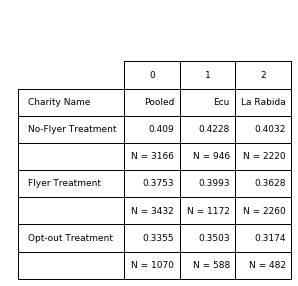

In [132]:
tabstat_A("Fund-Raising Treatments")

In [134]:
def tabstat_G(index_name):
    saidyes_Ecu = ["Ecu"]
    for x in ["Nw","W", "Oo"]:
        saidyes_Ecu.append(exp_df.loc[(exp_df["charity"] == "Ecu") & (exp_df["treatment"] == x), "saidyes"].mean())
        n = len(exp_df.loc[(exp_df["charity"] == "Ecu") & (exp_df["treatment"] == x), "charity"])
        saidyes_Ecu.append(f"N = {n}")
        
    saidyes_LR = ["La Rabida"]
    for x in ["Nw","W", "Oo"]:
        saidyes_LR.append(exp_df.loc[(exp_df["charity"] == "LaRabida") & (exp_df["treatment"] == x), "saidyes"].mean())
        n = len(exp_df.loc[(exp_df["charity"] == "LaRabida") & (exp_df["treatment"] == x), "charity"])
        saidyes_LR.append(f"N = {n}")
        
    saidyes_Pooled = ["Pooled"]
    for x in ["Nw","W", "Oo"]:
        saidyes_Pooled.append(exp_df.loc[((exp_df["charity"] == "Ecu") | (exp_df["charity"] == "LaRabida")) & \
                                            (exp_df["treatment"] == x), "saidyes"].mean())
        n = len(exp_df.loc[((exp_df["charity"] == "Ecu") | (exp_df["charity"] == "LaRabida")) & (exp_df["treatment"] == x),
                   "charity"])
        saidyes_Pooled.append(f"N = {n}")
    data = {"0": saidyes_Ecu,
           "1": saidyes_LR, 
           "2": saidyes_Pooled}
    index = ["Charity Name", "Baseline (No-Flyer) Treatment", " ", "Flyer Treatment", " ",  "Flyer with Opt-out Treatment", " "]
    df = pd.DataFrame(index = index, data = data)
    df.index.rename(index_name, inplace = True)
    fig = plt.figure(figsize = (8, 2))
    ax = fig.add_subplot(111)

    ax.table(cellText = df.values,
          rowLabels = df.index,
          colLabels = df.columns,
          loc = "center", 
             colWidths=[1 for x in df.columns],
          bbox=[0, -1.5, 1.5, 2])
    ax.set_title("Share of Households Giving (In-Person)", fontdict={'fontsize': 20, 'fontweight': 'medium'})

    ax.axis("off");
    return
    

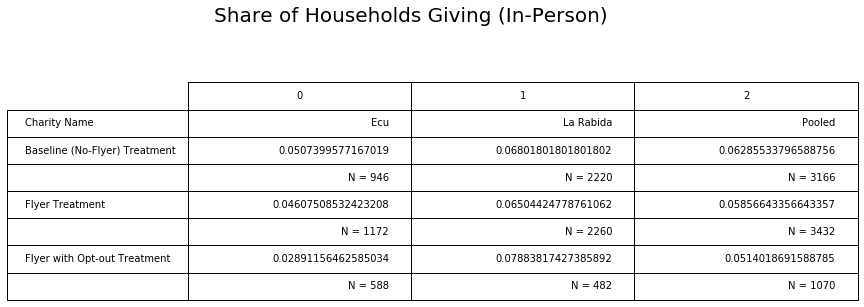

In [135]:
tabstat_G("Fund_Raising Treatments")

In [136]:
def tabstat08(index_name):
    answer = ["Sv2008"]
    for x in ["Nw0d10m", "W0d10m", "W0d5m", "W10d10m"]:
        answer.append(exp_df.loc[(exp_df["charity"] == "Sv2008") & (exp_df["treatment"] == x), "answer"].mean())
        n = len(exp_df.loc[(exp_df["charity"] == "Sv2008") & (exp_df["treatment"] == x), "charity"])
        answer.append(f"N = {n}")
    data = {" ": answer}
    index = ["Charity Name", "Baseline ($0/10min) Treatment", " ", "Flyer ($0/10min) Treatment", " ",  "Flyer ($0/5min) Treatment", 
             " ", "Flyer ($10/10min) Treatment", " "]
    df = pd.DataFrame(index = index, data = data)
    df.index.rename(index_name, inplace = True)
    fig = plt.figure(figsize = (8, 2))
    ax = fig.add_subplot(111)

    ax.table(cellText = df.values,
          rowLabels = df.index,
          colLabels = df.columns,
          loc = "center", 
             colWidths=[1 for x in df.columns],
          bbox=[0, -1.5, 1.5, 2])
    ax.set_title("Share of Households Answering the Door", fontdict={'fontsize': 20, 'fontweight': 'medium'})

    ax.axis("off");
    return
    

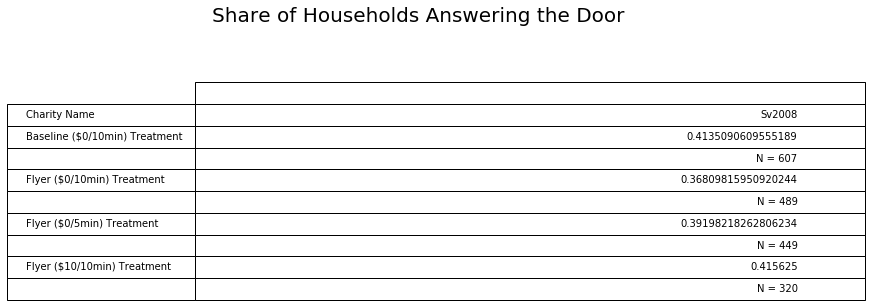

In [137]:
tabstat08("2008 Survey Treatments")

In [139]:
def tabstat09(index_name):
    answer = ["Sv2009"]
    for x in ["Nw0d5m", "Nw5d5m", "Oo0d5m", "Oo5d5m", "W0d10m", "W0d5m", "W10d5m", "W5d5m"]:
        answer.append(exp_df.loc[(exp_df["charity"] == "Sv2009") & (exp_df["treatment"] == x), "answer"].mean())
        n = len(exp_df.loc[(exp_df["charity"] == "Sv2009") & (exp_df["treatment"] == x), "charity"])
        answer.append(f"N = {n}")
    data = {" ": answer}
    index = ["Charity Name", "Baseline ($0/5min)", " ", "Baseline ($5/5min)", " ",
             "Flyer ($0/10min)", " ",  "Flyer ($0/5min)", " ", "Flyer ($5/5min)", " ", "Flyer ($10/5min)", " ", 
             "Opt-out ($0/5min)", " ", "Opt-out ($0/10min)", " "]
             
    df = pd.DataFrame(index = index, data = data)
    df.index.rename(index_name, inplace = True)
    fig = plt.figure(figsize = (8, 2))
    ax = fig.add_subplot(111)

    ax.table(cellText = df.values,
          rowLabels = df.index,
          colLabels = df.columns,
          loc = "center", 
             colWidths=[1 for x in df.columns],
          bbox=[0, -1.5, 1, 2.5])
    ax.set_title("Share of Households Answering the Door", fontdict={'fontsize': 20, 'fontweight': 'medium'})

    ax.axis("off");
    return
    

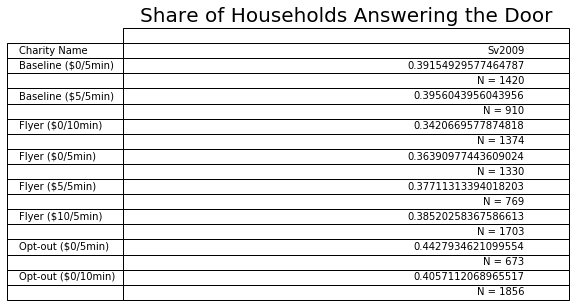

In [140]:
tabstat09("2009 Survey Treatments")

In [142]:
def table2():
    model1 = ols('answer ~ dW + dOo + dEcu + C(grsol) + C(grdatloc) + C(grhour) + C(grarea)', 
            data=exp_df.loc[exp_df["charityall"] == "All"])
    fitted_model1 = model1.fit(cov_type="cluster", cov_kwds={"groups": exp_df.loc[exp_df["charityall"] == "All", "sodate"]})
    f1 = []
    for x in [-3, -2, -1]:
        f1.append(fitted_model1.params[x])
        if fitted_model1.pvalues[x].round(5) <= 0.01:     
            bse = fitted_model1.bse[x]
            f1.append(f"({round(bse, 4)})***")
        elif fitted_model1.pvalues[x].round(5) <= 0.05:
            bse = fitted_model1.bse[x]
            f1.append(f"({round(bse, 4)})**")
            
        elif fitted_model1.pvalues[x].round(5) <= 0.1:    
            bse = fitted_model1.bse[x]
            f1.append(f"({round(bse, 4)})*")
        else:
            bse = fitted_model1.bse[x]
            f1.append(f"({round(bse, 4)})")
        
    model2 = ols('answer ~ dEcu + dWEcu + dOoEcu + dWLar + dOoLar + C(grsol) + C(grdatloc) + C(grhour) + C(grarea)',
             data = exp_df.loc[exp_df["charityall"] == "All"])
    fitted_model2 = model2.fit(cov_type="cluster", cov_kwds={"groups": exp_df.loc[exp_df["charityall"] == "All", "sodate"]})
    f2 = []
    for x in [-5, -4, -3, -2, -1]:
        f2.append(fitted_model2.params[x])
        if fitted_model2.pvalues[x].round(5) <= 0.01:     
            bse = fitted_model2.bse[x]
            f2.append(f"({round(bse, 4)})***")
        elif fitted_model2.pvalues[x].round(5) <= 0.05:
            bse = fitted_model2.bse[x]
            f2.append(f"({round(bse, 4)})**")
            
        elif fitted_model2.pvalues[x].round(5) <= 0.1:    
            bse = fitted_model2.bse[x]
            f2.append(f"({round(bse, 4)})*")
        else:
            bse = fitted_model2.bse[x]
            f2.append(f"({round(bse, 4)})")
            
    
    model3 = ols('saidyes ~ dW + dOo + dEcu + C(grsol) + C(grdatloc) + C(grhour) + C(grarea)', 
            data=exp_df.loc[exp_df["charityall"] == "All"])
    fitted_model3 = model3.fit(cov_type="cluster", cov_kwds={"groups": exp_df.loc[exp_df["charityall"] == "All", "sodate"]})
    f3 = []
    for x in [-3, -2, -1]:
        f3.append(fitted_model3.params[x])
        if fitted_model3.pvalues[x].round(5) <= 0.01:     
            bse = fitted_model3.bse[x]
            f3.append(f"({round(bse, 4)})***")
        elif fitted_model3.pvalues[x].round(5) <= 0.05:
            bse = fitted_model3.bse[x]
            f3.append(f"({round(bse, 4)})**")
            
        elif fitted_model3.pvalues[x].round(5) <= 0.1:    
            bse = fitted_model3.bse[x]
            f3.append(f"({round(bse, 4)})*")
        else:
            bse = fitted_model3.bse[x]
            f3.append(f"({round(bse, 4)})")
            
    model4 = ols('saidyes ~ dEcu + dWEcu + dOoEcu + dWLar + dOoLar + C(grsol) + C(grdatloc) + C(grhour) + C(grarea)',
             data = exp_df.loc[exp_df["charityall"] == "All"])
    fitted_model4 = model4.fit(cov_type="cluster", cov_kwds={"groups": exp_df.loc[exp_df["charityall"] == "All", "sodate"]})
    f4 = []
    for x in [-5, -4, -3, -2, -1]:
        f4.append(fitted_model4.params[x])
        if fitted_model4.pvalues[x].round(5) <= 0.01:     
            bse = fitted_model4.bse[x]
            f4.append(f"({round(bse, 4)})***")
        elif fitted_model4.pvalues[x].round(5) <= 0.05:
            bse = fitted_model4.bse[x]
            f4.append(f"({round(bse, 4)})**")
            
        elif fitted_model4.pvalues[x].round(5) <= 0.1:    
            bse = fitted_model4.bse[x]
            f4.append(f"({round(bse, 4)})*")
        else:
            bse = fitted_model4.bse[x]
            f4.append(f"({round(bse, 4)})")
            
    model5 = ols('yessmall ~ dW + dOo + dEcu + C(grsol) + C(grdatloc) + C(grhour) + C(grarea)', 
            data=exp_df.loc[exp_df["charityall"] == "All"])
    fitted_model5 = model5.fit(cov_type="cluster", cov_kwds={"groups": exp_df.loc[exp_df["charityall"] == "All", "sodate"]})
    f5 = []
    for x in [-3, -2, -1]:
        f5.append(fitted_model5.params[x])
        if fitted_model5.pvalues[x].round(5) <= 0.01:     
            bse = fitted_model5.bse[x]
            f5.append(f"({round(bse, 4)})***")
        elif fitted_model5.pvalues[x].round(5) <= 0.05:
            bse = fitted_model5.bse[x]
            f5.append(f"({round(bse, 4)})**")
            
        elif fitted_model5.pvalues[x].round(5) <= 0.1:    
            bse = fitted_model5.bse[x]
            f5.append(f"({round(bse, 4)})*")
        else:
            bse = fitted_model5.bse[x]
            f5.append(f"({round(bse, 4)})")
            
    model7 = ols('yeslarge ~ dW + dOo + dEcu + C(grsol) + C(grdatloc) + C(grhour) + C(grarea)', 
            data=exp_df.loc[exp_df["charityall"] == "All"])
    fitted_model7 = model7.fit(cov_type="cluster", cov_kwds={"groups": exp_df.loc[exp_df["charityall"] == "All", "sodate"]})
    f7 = []
    for x in [-3, -2, -1]:
        f7.append(fitted_model7.params[x])
        if fitted_model7.pvalues[x].round(5) <= 0.01:     
            bse = fitted_model7.bse[x]
            f7.append(f"({round(bse, 4)})***")
        elif fitted_model7.pvalues[x].round(5) <= 0.05:
            bse = fitted_model7.bse[x]
            f7.append(f"({round(bse, 4)})**")
            
        elif fitted_model7.pvalues[x].round(5) <= 0.1:    
            bse = fitted_model7.bse[x]
            f7.append(f"({round(bse, 4)})*")
        else:
            bse = fitted_model7.bse[x]
            f7.append(f"({round(bse, 4)})")
    
    index_name = ["Flyer Treatment", "",  "Flyer witht Opt-out Treatment", "",
                 "Indicator ECU Charity", "", "Flyer Treatment Ecu Charity", "",
                  "Flyer with opt out Ecu Charity",  "",  "Flyer Treatment La Rabida Charity",  "",
                 "Flyer with opt out La Rabida Charity",  "", "Mean of Dep. Var. for Omitted Treatment"]
    mean = []
    for x in ["answer", "saidyes", "yessmall", "yeslarge"]:
        m = exp_df.loc[(exp_df["charity"] == "LaRabida") & (exp_df["treatment"] == "Nw"), x].mean()
        mean.append(round(m, 3))
    
    data1 = {"0": f1 + ["", "", "", "", "", "", "", ""] + [mean[0]],
             "1": ["", "", "", ""] + f2 + [mean[0]],
             "2": f3 + ["", "", "", "", "", "", "", ""] + [mean[1]],
             "3": ["", "", "", ""] + f4 + [mean[1]]}
    
    df1 = pd.DataFrame(index = index_name, data = data1)
                       

    
    df2 = pd.DataFrame([df1.iloc[0, :].to_list(), df1.iloc[1, :].to_list(), df1.iloc[2, :].to_list(), 
                      df1.iloc[3, :].to_list(), df1.iloc[4, :].to_list(), df1.iloc[5, :].to_list(),
                      df1.iloc[6, :].to_list(), df1.iloc[7, :].to_list(), df1.iloc[8, :].to_list(),
                      df1.iloc[9, :].to_list(), df1.iloc[10, :].to_list(), df1.iloc[11, :].to_list(),
                      df1.iloc[12, :].to_list(), df1.iloc[13, :].to_list(), df1.iloc[14, :].to_list()],
                      index = pd.Index(index_name, name = "Independent Var."),
                      columns = pd.MultiIndex.from_product([["Indicator for Answering the Door",
                                                          "Indicator for Giving"], ["0", "1"]])) 
                                                           
    df2["Indicator for Small Amount(<= $10)"] = f5 + ["", "", "", "", "", "", "", ""] + [mean[2]]
    df2["Indicator for Large Amount(> $10)"] = f7 + ["", "", "", "", "", "", "", ""] + [mean[3]]

    
  
    
    return df2
    
    

In [266]:
table2

Indicator for Answering the Door  \
                                                                       0   
Independent Var.                                                           
Flyer Treatment                                               -0.0387395   
                                                             (0.0137)***   
Flyer witht Opt-out Treatment                                 -0.0966842   
                                                             (0.0194)***   
Indicator ECU Charity                                         0.00883088   
                                                                (0.0143)   
Flyer Treatment Ecu Charity                                                
                                                                           
Flyer with opt out Ecu Charity                                             
                                                                           
Flyer Treatment La Rabida Charity                                          
                                                                           
Flyer with opt out La Rabida Charity                                       
                                                                           
Mean of Dep. Var. for Omitted Treatment                            0.403   

                                                     Indicator for Giving  \
                                                   1                    0   
Independent Var.                                                            
Flyer Treatment                                               -0.00114816   
                                                                 (0.0062)   
Flyer witht Opt-out Treatment                                  -0.0195066   
                                                               (0.0084)**   
Indicator ECU Charity                     0.00409783           -0.0249368   
                                            (0.0234)          (0.0049)***   
Flyer Treatment Ecu Charity               -0.0364517                        
                                            (0.0313)                        
Flyer with opt out Ecu Charity            -0.0889622                        
                                         (0.0271)***                        
Flyer Treatment La Rabida Charity         -0.0396332                        
                                         (0.0144)***                        
Flyer with opt out La Rabida Charity        -0.10598                        
                                         (0.0319)***                        
Mean of Dep. Var. for Omitted Treatment        0.403                0.068   

                                                      \
                                                   1   
Independent Var.                                       
Flyer Treatment                                        
                                                       
Flyer witht Opt-out Treatment                          
                                                       
Indicator ECU Charity                     -0.0262778   
                                         (0.0085)***   
Flyer Treatment Ecu Charity              0.000611502   
                                            (0.0094)   
Flyer with opt out Ecu Charity             -0.018298   
                                             (0.01)*   
Flyer Treatment La Rabida Charity        -0.00188176   
                                            (0.0078)   
Flyer with opt out La Rabida Charity      -0.0202273   
                                            (0.0132)   
Mean of Dep. Var. for Omitted Treatment        0.068   

                                        Indicator for Small Amount(<= $10)  \
                                                                             
Independent Var.                                                             
Flyer Treatment                          

In [163]:
table2.to_csv("table2.csv")

In [1550]:
def table1Appendix():
    
    f1 = []
    f2 = []
    f3 = []
    for x in ["answer", "saidyes", "yessmall", "yeslarge"]:
        model1 = ols(f'{x} ~ dW + dOo + dEcu + C(grsol) + C(grdatloc) + C(grhour) + C(grarea)', 
                     data=exp_df.loc[exp_df["charityall"] == "All"])
        fitted_model1 = model1.fit(cov_type="cluster", 
                                   cov_kwds={"groups": exp_df.loc[exp_df["charityall"] == "All", "sodate"]})
    
        model3 = ols(f'{x} ~ dW + dOo + C(grdatlocsol) +  C(grhour) + C(grarea)', 
                     data=exp_df.loc[exp_df["charityall"] == "All"])
        fitted_model3 = model3.fit(cov_type="cluster", 
                                   cov_kwds={"groups": exp_df.loc[exp_df["charityall"] == "All", "sodate"]})
        
        model2 = ols(f'{x} ~ dW + dOo + C(grsol) + C(grdatloc) + C(grhour) + C(grarea)', 
                     data=exp_df.loc[exp_df["charityall"] == "All"])
        fitted_model2 = model2.fit(cov_type="cluster", 
                                   cov_kwds={"groups": exp_df.loc[exp_df["charityall"] == "All", "sodate"]})
        for x in ["dW", "dOo", "dEcu"]:
            f1.append(fitted_model1.params.loc[[x]][0])
            if fitted_model1.pvalues.loc[[x]][0].round(5) <= 0.01:     
                bse = fitted_model1.bse.loc[[x]][0]
                f1.append(f"({round(bse, 4)})***")
            elif fitted_model1.pvalues.loc[[x]][0].round(5) <= 0.05:
                bse = fitted_model1.bse.loc[[x]][0]
                f1.append(f"({round(bse, 4)})**")
            
            elif fitted_model1.pvalues.loc[[x]][0].round(5) <= 0.1:    
                bse = fitted_model1.bse.loc[[x]][0]
                f1.append(f"({round(bse, 4)})*")
            else:
                bse = fitted_model1.bse.loc[[x]][0]
                f1.append(f"({round(bse, 4)})")
        
        for y in ["dW", "dOo"]:
            f3.append(fitted_model3.params.loc[[y]][0])
            if fitted_model3.pvalues.loc[[y]][0].round(5) <= 0.01:
                bse = fitted_model3.bse.loc[[y]][0]
                f3.append(f"({round(bse, 4)})***")
            elif fitted_model3.pvalues.loc[[y]][0].round(5) <= 0.05:
                bse = fitted_model3.bse.loc[[y]][0]
                f3.append(f"({round(bse, 4)})**")
            
            elif fitted_model3.pvalues.loc[[y]][0].round(5) <= 0.1:    
                bse = fitted_model3.bse.loc[[y]][0]
                f3.append(f"({round(bse, 4)})*")
            else:
                bse = fitted_model3.bse.loc[[y]][0]
                f3.append(f"({round(bse, 4)})")
        for x in ["dW", "dOo"]:
            f2.append(fitted_model2.params.loc[[x]][0])
            if fitted_model2.pvalues.loc[[x]][0].round(5) <= 0.01:  
                bse = fitted_model2.bse.loc[[x]][0]
                f2.append(f"({round(bse, 4)})***")
            elif fitted_model2.pvalues.loc[[x]][0].round(5) <= 0.05:
                bse = fitted_model2.bse.loc[[x]][0]
                f2.append(f"({round(bse, 4)})**")
            
            elif fitted_model2.pvalues.loc[[x]][0].round(5) <= 0.1:    
                bse = fitted_model2.bse.loc[[x]][0]
                f2.append(f"({round(bse, 4)})*")
            else:
                bse = fitted_model2.bse.loc[[x]][0]
                f2.append(f"({round(bse, 4)})")
    data1 = {"1": f1[0:6], 
                 "2": f2[0:4] + ["", ""], 
                "3": f3[0:4] + ["", ""], 
                 "4": f1[6:12], 
                 "5": f2[4:8] + ["", ""],
                "6": f3[4:8] + ["", ""], 
                 "7": f1[12:18], 
                 "8": f2[8:12] + ["", ""], 
                 "9": f3[8:12] + ["", ""],
                "10": f1[18:24], 
                 "11": f2[12:16] + ["", ""], 
                 "12": f3[12:16] + ["", ""]}
    
    index1 = ["Flyer Treatment", "", "Flyer with opt-out Treatment", "", "Indicator ECU Charity", ""]
        
    df1 = pd.DataFrame(index = index1, data = data1)
    df2 = pd.DataFrame([df1.iloc[0, :].to_list(), df1.iloc[1, :].to_list(), df1.iloc[2, :].to_list(), 
                      df1.iloc[3, :].to_list(), df1.iloc[4, :].to_list(), df1.iloc[5, :].to_list()],
                      index = pd.Index(index1, name = "Independent Var."),
                      columns = pd.MultiIndex.from_product([["Indicator for Answering the Door", "Indicator for Giving", 
                                                         "Indicator for Giving Small Amount(<=$10)",
                                                          "Indicator for Giving Large Amount(>$10)"], ["0", "1", "2"]]))
    return df2
 
        

In [1551]:
table1Appendix()

Indicator for Answering the Door                            \
                                                            0            1            2   
Independent Var.                                                                          
Flyer Treatment              -0.0387395                       -0.0388276   -0.0382681     
                              (0.0137)***                      (0.0137)***  (0.014)***    
Flyer with opt-out Treatment -0.0966842                       -0.0966128   -0.0984042     
                              (0.0194)***                      (0.0193)***  (0.0195)***   
Indicator ECU Charity         0.00883088                                                  
                              (0.0143)                                                    

                             Indicator for Giving                           \
                                                0            1           2   
Independent Var.                                                             
Flyer Treatment              -0.00114816          -0.000899421 -0.00150014   
                              (0.0062)             (0.0062)     (0.0063)     
Flyer with opt-out Treatment -0.0195066           -0.0197081   -0.02036      
                              (0.0084)**           (0.0083)**   (0.0085)**   
Indicator ECU Charity        -0.0249368                                      
                              (0.0049)***                                    

                             Indicator for Giving Small Amount(<=$10)                          \
                                                                    0           1           2   
Independent Var.                                                                                
Flyer Treatment              -0.00331242                              -0.00318613 -0.00269827   
                              (0.0052)                                 (0.0051)    (0.0053)     
Flyer with opt-out Treatment -0.0193074                               -0.0194097  -0.0190808    
                              (0.0081)**                               (0.008)**   (0.0082)**   
Indicator ECU Charity        -0.0126605                                                         
                              (0.0053)**                                                        

                             Indicator for Giving Large Amount(>$10)                          
                                                                   0           1           2  
Independent Var.                                                                              
Flyer Treatment               0.00216425                              0.00228671  0.00119813  
                              (0.0035)                                (0.0035)    (0.0035)    
Flyer with opt-out Treatment -0.000199201                            -0.00029844 -0.0012792   
                              (0.0051)                                (0.0051)    (0.0052)    
Indicator ECU Charity        -0.0122763                                                       
                              (0.0032)***

In [72]:
def table2Appendix():
    f1 = []
    for x in ["answer", "saidyes", "yessmall", "yeslarge"]:
        model1 = ols(f'{x} ~ dW + dOo + dEcu + C(grsol) + C(grdatloc) + C(grhour) + C(grarea)', 
                     data=exp_df.loc[(exp_df["charityall"] == "All") & (exp_df["dwave"] == 0)])
        fitted_model1 = model1.fit(cov_type="cluster", 
                                   cov_kwds={"groups": exp_df.loc[(exp_df["charityall"] == "All") & (exp_df["dwave"] == 0), 
                                                                  "sodate"]})
        
        for x in ["dW", "dOo", "dEcu"]:
            f1.append(fitted_model1.params.loc[[x]][0])
            if fitted_model1.pvalues.loc[[x]][0].round(5) <= 0.01:
                bse = fitted_model1.bse.loc[[x]][0]
                f1.append(f"({round(bse, 4)})***")
            elif fitted_model1.pvalues.loc[[x]][0].round(5) <= 0.05:
                bse = fitted_model1.bse.loc[[x]][0]
                f1.append(f"({round(bse, 4)})**")
            
            elif fitted_model1.pvalues.loc[[x]][0].round(5) <= 0.1:    
                bse = fitted_model1.bse.loc[[x]][0]
                f1.append(f"({round(bse, 4)})*")
            else:
                bse = fitted_model1.bse.loc[[x]][0]
                f1.append(f"({round(bse, 4)})")
    for x in ["answer", "saidyes", "yessmall", "yeslarge"]:
        model1 = ols(f'{x} ~ dW + dOo + dEcu + C(grsol) + C(grdatloc) + C(grhour) + C(grarea)', 
                     data=exp_df.loc[(exp_df["charityall"] == "All") & (exp_df["dwave"] == 1)])
        fitted_model1 = model1.fit(cov_type="cluster", 
                                   cov_kwds={"groups": exp_df.loc[(exp_df["charityall"] == "All") & (exp_df["dwave"] == 1), 
                                                                  "sodate"]})
        f1.append(fitted_model1.params.loc[["dW"]][0])
        if fitted_model1.pvalues.loc[["dW"]][0].round(5) <= 0.01:
            
            bse = fitted_model1.bse.loc[["dW"]][0]
            f1.append(f"({round(bse, 4)})***")
        elif fitted_model1.pvalues.loc[["dW"]][0].round(5) <= 0.05:
            bse = fitted_model1.bse.loc[["dW"]][0]
            f1.append(f"({round(bse, 4)})**")
        elif fitted_model1.pvalues.loc[["dW"]][0].round(5) <= 0.1: 
            bse = fitted_model1.bse.loc[["dW"]][0]
            f1.append(f"({round(bse, 4)})*")
        else:
            bse = fitted_model1.bse.loc[["dW"]][0]
            f1.append(f"({round(bse, 4)})")
            
    data1 = {"0": f1[0:6], 
             "1": f1[24:26] + ["", "", "", ""],
             "3": f1[6:12], 
             "4": f1[26:28] + ["", "", "", ""],
             "5": f1[12:18], 
             "6": f1[28:30] + ["", "", "", ""],
             "7": f1[18:24],
             "8": f1[30:32] + ["", "", "", ""]}
    index1 = ["Flyer Treatment", "", "Flyer with opt-out Treatment", "", "Indicator ECU Charity", ""]
    df1 = pd.DataFrame(index = index1, data = data1)
    df2 = pd.DataFrame([df1.iloc[0, :].to_list(), df1.iloc[1, :].to_list(), df1.iloc[2, :].to_list(), 
                      df1.iloc[3, :].to_list(), df1.iloc[4, :].to_list(), df1.iloc[5, :].to_list()],
                      index = pd.Index(index1, name = "Independent Var."),
                      columns = pd.MultiIndex.from_product([["Indicator for Answering the Door", "Indicator for Giving", 
                                                         "Indicator for Giving Small Amount(<=$10)",
                                                          "Indicator for Giving Large Amount(>$10)"], ["0", "1"]]))
 
    return  df2
        
    
    

In [75]:
table2Appendix()

C:\Users\Lenovo\Anaconda3\lib\site-packages\statsmodels\base\model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\Lenovo\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Lenovo\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\Lenovo\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Indicator for Answering the Door               \
                                                            0            1   
Independent Var.                                                             
Flyer Treatment                                     -0.036071   -0.0428253   
                                                     (0.0291)  (0.0159)***   
Flyer with opt-out Treatment                        -0.102273                
                                                   (0.028)***                
Indicator ECU Charity                             -0.00404869                
                                                      (0.017)                

                             Indicator for Giving              \
                                                0           1   
Independent Var.                                                
Flyer Treatment                       -0.00447449 -0.00133313   
                                         (0.0116)    (0.0094)   
Flyer with opt-out Treatment           -0.0253861               
                                        (0.0134)*               
Indicator ECU Charity                    -0.02443               
                                      (0.0079)***               

                             Indicator for Giving Small Amount(<=$10)  \
                                                                    0   
Independent Var.                                                        
Flyer Treatment                                           -0.00624139   
                                                             (0.0101)   
Flyer with opt-out Treatment                                -0.026112   
                                                           (0.0124)**   
Indicator ECU Charity                                     -0.00862097   
                                                             (0.0065)   

                                           \
                                        1   
Independent Var.                            
Flyer Treatment               0.000395772   
                                 (0.0079)   
Flyer with opt-out Treatment                
                                            
Indicator ECU Charity                       
                                            

                             Indicator for Giving Large Amount(>$10)  \
                                                                   0   
Independent Var.                                                       
Flyer Treatment                                           0.00176691   
                                                            (0.0067)   
Flyer with opt-out Treatment                             0.000725835   
                                                            (0.0071)   
Indicator ECU Charity                                      -0.015809   
                                                         (0.0042)***   

                                         
                                      1  
Independent Var.                         
Flyer Treatment              -0.0017289  
                               (0.0049)  
Flyer with opt-out Treatment             
                                         
Indicator ECU Charity

In [165]:
def table3():
    f1 = []
    for x in ["answer", "saidyes"]:
        model1 = ols(f'{x} ~ dW0d10m08 + dW0d5m08 + dW10d10m08 + C(grsol) + C(grdatloc) + C(grhour) + C(grarea)', 
                     data=exp_df.loc[exp_df["charity"] == "Sv2008"])
        fitted_model1 = model1.fit(cov_type="HC1")
        for x in ["dW0d10m08", "dW0d5m08", "dW10d10m08"]:
            f1.append(fitted_model1.params.loc[[x]][0])
            if fitted_model1.pvalues.loc[[x]][0].round(5) <= 0.01:
                bse = fitted_model1.bse.loc[[x]][0]
                f1.append(f"({round(bse, 4)})***")
            elif fitted_model1.pvalues.loc[[x]][0].round(5) <= 0.05:
                bse = fitted_model1.bse.loc[[x]][0]
                f1.append(f"({round(bse, 4)})**")
            
            elif fitted_model1.pvalues.loc[[x]][0].round(5) <= 0.1:    
                bse = fitted_model1.bse.loc[[x]][0]
                f1.append(f"({round(bse, 4)})*")
            else:
                bse = fitted_model1.bse.loc[[x]][0]
                f1.append(f"({round(bse, 4)})")
    f2 = []
    for x in ["answer", "saidyes"]:
        model1 = ols(f'{x} ~ dNw5d5m09 + dW0d10m09 + dW0d5m09 + dW5d5m09 + dW10d5m09 + dOo0d5m09 + dOo5d5m09 + \
        C(grsol) + C(grdatloc) + C(grhour) + C(grarea)', 
                     data=exp_df.loc[exp_df["charity"] == "Sv2009"])
        fitted_model1 = model1.fit(cov_type="cluster", 
                                   cov_kwds={"groups": exp_df.loc[exp_df["charity"] == "Sv2009", 
                                                                  "sodate"]}, use_t = False)
        for x in ["dNw5d5m09", "dW0d10m09", "dW0d5m09", "dW5d5m09", "dW10d5m09", "dOo0d5m09", "dOo5d5m09"]:
            f2.append(fitted_model1.params.loc[[x]][0])
            if fitted_model1.pvalues.loc[[x]][0].round(5) <= 0.01:
                bse = fitted_model1.bse.loc[[x]][0]
                f2.append(f"({round(bse, 4)})***")
            elif fitted_model1.pvalues.loc[[x]][0].round(5) <= 0.05:
                bse = fitted_model1.bse.loc[[x]][0]
                f2.append(f"({round(bse, 4)})**")
            
            elif fitted_model1.pvalues.loc[[x]][0].round(5) <= 0.1:    
                bse = fitted_model1.bse.loc[[x]][0]
                f2.append(f"({round(bse, 4)})*")
            else:
                bse = fitted_model1.bse.loc[[x]][0]
                f2.append(f"({round(bse, 4)})")
    data = {"0": f1[0:6] + ["", "", "", "", "", "", "", "", "", "", "", "", "", ""], 
            "1": f1[6:] + ["", "", "", "", "", "", "", "", "", "", "", "", "", ""], 
            "2": ["", "", "", "", "", ""] + f2[0:14],
            "3": ["", "", "", "", "", ""] + f2[14:]}
    index = ["Flyer ($0/10min) Treatment", "", "Flyer ($0/5min) Treatment", "",
             "Flyer ($10/10min) Treatment", "", "Baseline ($5/5min) Treatment", "",
             "Flyer ($0/10min) Treatment", "", "Flyer ($0/5min) Treatment", "",
            "Flyer ($5/5min) Treatment", "", "Flyer ($10/5min) Treatment", "",
            "Opt-out ($0/5min) Treatment", "", "Opt-out ($5/5min) Treatment", ""]
    df1 = pd.DataFrame(index = index, data = data)
    df2 = pd.DataFrame([df1.iloc[0, :].to_list(), df1.iloc[1, :].to_list(), df1.iloc[2, :].to_list(), 
                      df1.iloc[3, :].to_list(), df1.iloc[4, :].to_list(), df1.iloc[5, :].to_list(),
                      df1.iloc[6, :].to_list(), df1.iloc[7, :].to_list(), df1.iloc[8, :].to_list(), 
                      df1.iloc[9, :].to_list(), df1.iloc[10, :].to_list(), df1.iloc[11, :].to_list(),
                      df1.iloc[12, :].to_list(), df1.iloc[13, :].to_list(), df1.iloc[14, :].to_list(), 
                      df1.iloc[15, :].to_list(), df1.iloc[16, :].to_list(), df1.iloc[17, :].to_list(),
                      df1.iloc[18, :].to_list(), df1.iloc[19, :].to_list()],
                      index = pd.Index(index, name = "Dependent Var:"),
                      columns = pd.MultiIndex.from_product([["2008 Survey", "2009 Survey"], 
                                                            ["Indicator for Answering the Door", 
                                                             "Indicator for Completing the Survey"]]))
    
    return df2
        
        
        
        
    


In [166]:
table3 = table3()

In [167]:
table3.to_csv("table3.csv")

---
# 3. Moment Estimation <a class="anchor" id="moments"></a>
---

In [ ]:
### Set the type of moments to be generated
for x in ["010", "010-10", "03-37-710", "010-10p", "all"]:
    exp = pd.read_stata(r"C:\Users\Lenovo\Desktop\Master_Thesis\CharityOutputQJEFinal.dta")
    exp.drop(columns = ["index"], inplace = True)
    exp["mom"] = x
    
    # Brief Data Cleaning
    exp.loc[(exp["charity"] == "La Rabida") | (exp["charity"] == "LaRabida"), "charity"] = "Lar"
    exp["optout"] = exp["dnd"]
    for x in ["0", 5, 10]:
        for y in [5, 10]:
            for z in ["Nw", "We", "Ooe", "W", "Oo"]:
                exp.loc[exp["treatment"] == f"{z}-{x}d{y}m", "treatment"] = f"{z}{x}d{y}m"
                exp.loc[((exp["treatment"] == f"{z}{x}d{y}m") & ~(z == "Oo")) | (exp["treatment"] == "Nw") | \
                        (exp["treatment"] == "W"), "optout"] = 0
                for yr in ["08", "09"]:
                    exp.loc[(exp["treatment"] == f"{z}{x}d{y}m") & ((x == "0") & (z == "W") & ((y == 5) | (y == 10)) & \
                                                                    (exp["year"] == int(f"{20}{yr}"))), 
                                                                    "treatment"] = f"{z}{x}d{y}m{yr}"
                    
    # Generate dependent variables
    exp.rename(columns={"answer": "outcomeans", "saidyes": "outcomeyes", "optout": "outcomeopt"}, inplace = True)
    
    ## This set of moments is to do Figure 5
    if exp["mom"].all() =="010-10p":
        exp.loc[(exp["treatment"] == "Nw") | (exp["treatment"] == "Oo") | (exp["treatment"] == "W"), 
                "outcomedona010"] = ((exp["amt_donate"] > 0) & (exp["amt_donate"] <= 10)) * 1
        exp.loc[(exp["treatment"] == "Nw") | (exp["treatment"] == "Oo") | (exp["treatment"] == "W"), 
                "outcomedonb10p"] = ((exp["amt_donate"] > 10) & (exp.loc[~exp["amt_donate"].isnull(), "amt_donate"])) * 1

        
    ## This set of moments is to do Figure 6
    elif exp["mom"].all() =="all":
        exp.loc[(exp["treatment"] == "Nw") | (exp["treatment"] == "Oo") | (exp["treatment"] == "W"), 
                "outcomedona02"] = ((exp["amt_donate"] > 0) & (exp["amt_donate"] < 2)) * 1
        exp.loc[(exp["treatment"] == "Nw") | (exp["treatment"] == "Oo") | (exp["treatment"] == "W"), 
                "outcomedonb2"] = (exp["amt_donate"] == 2) * 1
        exp.loc[(exp["treatment"] == "Nw") | (exp["treatment"] == "Oo") | (exp["treatment"] == "W"), 
                "outcomedonc25"] = ((exp["amt_donate"] > 2) & (exp["amt_donate"] < 5)) * 1
        exp.loc[(exp["treatment"] == "Nw") | (exp["treatment"] == "Oo") | (exp["treatment"] == "W"), 
                "outcomedond5"] = (exp["amt_donate"] == 5) * 1
        exp.loc[(exp["treatment"] == "Nw") | (exp["treatment"] == "Oo") | (exp["treatment"] == "W"), 
                "outcomedone510"] = ((exp["amt_donate"] > 5) & (exp["amt_donate"] < 10)) * 1
        exp.loc[(exp["treatment"] == "Nw") | (exp["treatment"] == "Oo") | (exp["treatment"] == "W"), 
                "outcomedonf10"] = (exp["amt_donate"] == 10) * 1
        exp.loc[(exp["treatment"] == "Nw") | (exp["treatment"] == "Oo") | (exp["treatment"] == "W"), 
                "outcomedong1020"] = ((exp["amt_donate"] > 10) & (exp["amt_donate"] < 20)) * 1
        exp.loc[(exp["treatment"] == "Nw") | (exp["treatment"] == "Oo") | (exp["treatment"] == "W"), 
                "outcomedonh20"] = (exp["amt_donate"] == 20) * 1
        exp.loc[(exp["treatment"] == "Nw") | (exp["treatment"] == "Oo") | (exp["treatment"] == "W"), 
                "outcomedoni2050"] = ((exp["amt_donate"] > 20) & (exp["amt_donate"] < 50)) * 1
        exp.loc[(exp["treatment"] == "Nw") | (exp["treatment"] == "Oo") | (exp["treatment"] == "W"), 
                "outcomedonj50"] = (exp["amt_donate"] == 50) * 1
        exp.loc[(exp["treatment"] == "Nw") | (exp["treatment"] == "Oo") | (exp["treatment"] == "W"), 
                "outcomedonk50p"] = ((exp["amt_donate"] > 50) & (exp.loc[~exp["amt_donate"].isnull(), "amt_donate"])) * 1

        
    ## This set of moments is for the Online Appendix Tables (less detailed moments)
    elif exp["mom"].all() = "010":
        exp.loc[(exp["treatment"] == "Nw") | (exp["treatment"] == "Oo") | (exp["treatment"] == "W"), 
                "outcomedona010"] = ((exp["amt_donate"] > 0) & (exp["amt_donate"] <= 10)) * 1
        exp.loc[(exp["treatment"] == "Nw") | (exp["treatment"] == "Oo") | (exp["treatment"] == "W"), 
                "outcomedonb1020"] = ((exp["amt_donate"] > 10) & (exp["amt_donate"] <= 20)) * 1
        exp.loc[(exp["treatment"] == "Nw") | (exp["treatment"] == "Oo") | (exp["treatment"] == "W"), 
                "outcomedonc2050"] = ((exp["amt_donate"] > 20) & (exp["amt_donate"] <= 50)) * 1
        exp.loc[(exp["treatment"] == "Nw") | (exp["treatment"] == "Oo") | (exp["treatment"] == "W"), 
                "outcomedond50p"] = ((exp["amt_donate"] > 50) & (exp.loc[~exp["amt_donate"].isnull(), "amt_donate"])) * 1
        
    ## Benchmark set of moments
    ## Use for Figures 4 and 7
    elif exp["mom"].all() =="010-10":
        exp.loc[(exp["treatment"] == "Nw") | (exp["treatment"] == "Oo") | (exp["treatment"] == "W"), 
                "outcomedona010"] = ((exp["amt_donate"] > 0) & (exp["amt_donate"] < 10)) * 1
        exp.loc[(exp["treatment"] == "Nw") | (exp["treatment"] == "Oo") | (exp["treatment"] == "W"), 
                "outcomedonb10"] = (exp["amt_donate"] == 10) * 1
        exp.loc[(exp["treatment"] == "Nw") | (exp["treatment"] == "Oo") | (exp["treatment"] == "W"), 
                "outcomedonc1020"] = ((exp["amt_donate"] > 10) & (exp["amt_donate"] <= 20)) * 1
        exp.loc[(exp["treatment"] == "Nw") | (exp["treatment"] == "Oo") | (exp["treatment"] == "W"), 
                "outcomedond2050"] = ((exp["amt_donate"] > 20) & (exp["amt_donate"] <= 50)) * 1
        exp.loc[(exp["treatment"] == "Nw") | (exp["treatment"] == "Oo") | (exp["treatment"] == "W"), 
                "outcomedone50p"] = ((exp["amt_donate"] > 50) & (exp.loc[~exp["amt_donate"].isnull(), "amt_donate"])) * 1

        
    ## This set of moments is for the Online Appendix Tables (more detailed moments)
    else:
        exp.loc[(exp["treatment"] == "Nw") | (exp["treatment"] == "Oo") | (exp["treatment"] == "W"), 
                "outcomedona03"] = ((exp["amt_donate"] > 0) & (exp["amt_donate"] <= 3)) * 1
        exp.loc[(exp["treatment"] == "Nw") | (exp["treatment"] == "Oo") | (exp["treatment"] == "W"), 
                "outcomedonb37"] = ((exp["amt_donate"] > 3) & (exp["amt_donate"] <= 7)) * 1
        exp.loc[(exp["treatment"] == "Nw") | (exp["treatment"] == "Oo") | (exp["treatment"] == "W"), 
                "outcomedonc710"] = ((exp["amt_donate"] > 7) & (exp["amt_donate"] <= 10)) * 1
        exp.loc[(exp["treatment"] == "Nw") | (exp["treatment"] == "Oo") | (exp["treatment"] == "W"), 
                "outcomedond1020"] = ((exp["amt_donate"] > 10) & (exp["amt_donate"] <= 20)) * 1
         exp.loc[(exp["treatment"] == "Nw") | (exp["treatment"] == "Oo") | (exp["treatment"] == "W"), 
                "outcomedone2050"] = ((exp["amt_donate"] > 20) & (exp["amt_donate"] <= 50)) * 1
        exp.loc[(exp["treatment"] == "Nw") | (exp["treatment"] == "Oo") | (exp["treatment"] == "W"), 
                "outcomedonf50p"] = ((exp["amt_donate"] > 50) & (exp.loc[~exp["amt_donate"].isnull(), "amt_donate"])) * 1
        
        
    
    exp.drop(columns = ['didsurvey', 'hypgivelo', 'hypgivehi', 'yeslarge', 
                   'yessmall', 'yeslarge2', 'yessmall2', 'lamt_donate',
                   'minutes',  'saidyescond', 
                   'charityall',  'month', 'dwave', 'treatmentby', 'amt_donate', 'dnd'], inplace = True)
    
    ### Begin stacked approach
    # Reshape to be able to do calculations of parameters easily
    exp["id"] = range(1, len(exp) + 1)
    exp = pd.melt(exp, id_vars = ["id", "charity", "treatment", "date", "location", 
                                "year", "mom", "sodate", 'grsol', 'grdatloc',
                                "grdatlocsol", "grhour", "grarea"],
                       value_name = "outcome")
    exp = exp.sort_values(["id", "variable"])
    exp.rename(columns = {"variable": "outc"}, inplace = True)
    exp.reset_index(inplace = True, drop = True)
    if exp["mom"].all() == "010":
        exp["outc"].replace({'outcomeans': 'ans', 'outcomedona010': 'don010',
                    'outcomedonb1020': 'don1020', 'outcomedonc2050': 'don2050',
                     'outcomedond50p': 'don50p', 'outcomeopt': 'opt', 'outcomeyes': 'yes'}, inplace=True)
    elif exp["mom"].all() == "010-10p":
        exp["outc"].replace({'outcomeans': 'ans', 'outcomedona010': 'don010',
                    'outcomedonb10p': 'don10p', 'outcomeopt': 'opt', 'outcomeyes': 'yes'}, inplace=True)
    elif exp["mom"].all() == "all":
        exp["outc"].replace({'outcomeans': 'ans', 'outcomedona02': 'don02',
                    'outcomedonb2': 'don2', "outcomedonc25": "don25", "outcomedond5": "don5", 
                     "outcomedone510": "don510", "outcomedonf10": "don10", "outcomedong1020": "don1020",
                     "outcomedonh20": "don20", "outcomedoni2050": "don2050", "outcomedonj50": "don50", 
                     "outcomedonk50p": "don50p",'outcomeopt': 'opt', 'outcomeyes': 'yes'}, inplace=True)
    elif exp["mom"].all() == "010-10":
        exp["outc"].replace({'outcomeans': 'ans', "outcomedona010": 'don010',
                    "outcomedonb10": 'don10', "outcomedonc1020": "don1020", "outcomedond2050": "don2050", 
                     "outcomedone50p": "don50p", 'outcomeopt': 'opt', 'outcomeyes': 'yes'}, inplace=True)
    else:
        exp["outc"].replace({'outcomeans': 'ans', "outcomedona03": "don03", "outcomedonb37": "don37",
                                 "outcomedonc710": "don710", "outcomedond1020": "don1020", "outcomedone2050": "don2050",
                                 "outcomedonf50p": "don50p", 'outcomeopt': 'opt', 'outcomeyes': 'yes'}, inplace=True)
        
    
    #  Define new dependent variables as dummies
    for z in ["ans", "yes"]:
        for x in ["Nw0d10m", "Nw0d5m", "Nw5d5m", "Oo0d5m", "Oo5d5m",
                  "W0d10m08", "W0d5m08", "W0d10m09", "W0d5m09", "W10d10m", "W10d5m", "W5d5m"]:
            exp[f"tr{z}{x}"] = ((exp["treatment"] == x) & (exp["outc"] == z)) * 1
            
        for x in ["Nw", "Oo", "W"]:
            for y in ["Ecu", "Lar"]:
                exp[f"tr{z}{x}{y}"] = ((exp["treatment"] == x) & (exp["charity"] == y) & (exp["outc"] == z)) * 1
    for z in ["opt"]:
        for x in ["Oo"]:
            for y in ["Ecu", "Lar"]:
                exp[f"tr{z}{x}{y}"] = ((exp["treatment"] == x) & (exp["charity"] == y) & (exp["outc"] == z)) * 1
        for x in ["Oo0d5m", "Oo5d5m"]:
            exp[f"tr{z}{x}"] = ((exp["treatment"] == x) & (exp["outc"] == z)) * 1 
    
    for z in ["03", "37", "710", "010", "10", "1020", "2050", "50p", "10p", "02", "2",  "25", "5", "510", "20", "50"]:
        # Here aggregate between ECU and LaRabida to do Figures 5 and 6
        for x in ["Nw", "Oo", "W"]:
            if ((exp["mom"].all() == "all") | (exp["mom"].all() == "010-10p")):
                exp[f"tr{z}{x}"] = ((exp["treatment"] == x) & (exp["outc"] == f"don{z}")) * 1
                if (((exp["mom"].all() =="all") & ((z =="03")| (z=="37")| (z =="710")|  (z =="010")| (z =="10p"))) | \
                    ((exp["mom"].all() =="010-10p") & ~((z =="010")| (z=="10p")))):
                    exp = exp.drop(f"tr{z}{x}", axis = 1)
            elif ((exp["mom"].all() =="010")|(exp["mom"].all() =="010-10")| (exp["mom"].all() =="03-37-710")):
                for y in ["Ecu", "Lar"]:
                    exp[f"tr{z}{x}{y}"] = ((exp["treatment"] == x) & (exp["outc"] == f"don{z}") & \
                                        (exp["charity"] == y)) * 1
                    if (((z =="10p")| (z =="02")|(z =="2")| (z =="25")| (z =="5")| \
                       (z =="510")| (z =="20")| (z =="50")) | \
                       ((exp["mom"].all() =="010") & ((z=="03")| (z =="37")| (z =="710")| (z =="10"))) | \
                       ((exp["mom"].all() =="010-10") & ((z =="03")|(z =="37")|(z =="710"))) | \
                       ((exp["mom"].all() =="03-37-710") & ((z =="010")|(z =="10")))):
                        exp = exp.drop(f"tr{z}{x}{y}", axis = 1)

                          
    #  Keep only outcomes for relevant treatments
    exp = exp.loc[~((exp["outc"]=="opt") & (~((exp["treatment"]=="Oo")|(exp["treatment"]=="Oo0d5m")|\
                                              (exp["treatment"]=="Oo5d5m"))))]
    exp = exp.loc[~((~((exp["outc"]=="ans")|(exp["outc"]=="yes")|(exp["outc"]=="opt"))) & \
              (~((exp["treatment"]=="Nw")|(exp["treatment"]=="W")|(exp["treatment"]=="Oo"))))]
    exp.reset_index(inplace= True, drop = True)
    
    if ((exp["mom"].all() =="all")|(exp["mom"].all() =="010-10p")):
        exp = exp.drop(exp.filter(regex='trans*', axis = 1), axis=1)
        exp = exp.drop(exp.filter(regex='tryes*', axis = 1), axis=1)
        exp = exp.drop(exp.filter(regex='tropt*', axis = 1), axis=1)
        exp = exp.loc[~((exp["outc"] == "ans") | (exp["outc"] == "opt") | (exp["outc"] == "yes"))]
        
    exp.loc[exp["charity"] == "Sv2008", "sv"] = "sv08"
    exp.loc[exp["charity"] == "Sv2009", "sv"] =  "sv09"
    exp["outcsv"] = exp.loc[~exp["outc"].isnull(), "outc"].astype("str") + exp.loc[~exp["sv"].isnull(), "sv"].astype("str") 
    exp.loc[exp["sv"].isnull(), "outcsv"] = exp["outc"]
    exp = exp.drop(["location", "charity", "treatment", "date", "sv"], axis = 1)
    
    # Change the order of variables
    if exp["mom"].all() == "010-10p":
        exp = exp[["id", "year", "mom", "sodate", 'grsol', 'grdatloc',
                   "grdatlocsol", "grhour", "grarea", "outc", "outcsv", "outcome",
                  "tr010Nw", "tr010Oo", "tr010W", "tr10pNw", "tr10pOo", "tr10pW"]]
    elif exp["mom"].all() =="all":
        exp = exp[["id", "year", "mom", "sodate", 'grsol', 'grdatloc',
                   "grdatlocsol", "grhour", "grarea", "outc", "outcsv", "outcome", 
                   "tr02Nw", "tr02Oo", "tr02W", "tr2Nw", "tr2Oo", "tr2W", 
                   "tr25Nw", "tr25Oo", "tr25W", "tr5Nw","tr5Oo", "tr5W", 
                   "tr510Nw", "tr510Oo", "tr510W", "tr10Nw", "tr10Oo", "tr10W",
                   "tr1020Nw", "tr1020Oo", "tr1020W", "tr20Nw", "tr20Oo", "tr20W",
                   "tr2050Nw", "tr2050Oo", "tr2050W", "tr50Nw", "tr50Oo", "tr50W",
                   "tr50pNw", "tr50pOo", "tr50pW"]]
    elif exp["mom"].all() =="010":
        exp = exp[["id", "year", "mom", "sodate", 'grsol', 'grdatloc',
                   "grdatlocsol", "grhour", "grarea", "outc", "outcsv", "outcome",
                  "transNwLar", "transNwEcu", "transWLar", "transWEcu", "transOoLar", "transOoEcu", 
                   "transNw0d10m", "transW0d5m08", "transW0d10m08", "transW10d10m", 
                    "tryesNwLar", "tryesNwEcu", "tryesWLar", "tryesWEcu", "tryesOoLar", "tryesOoEcu", 
                   "tryesNw0d10m", "tryesW0d5m08", "tryesW0d10m08", "tryesW10d10m", 
                    "troptOoLar", "troptOoEcu", "transNw0d5m", "transNw5d5m", "transOo0d5m", "transOo5d5m", 
                   "transW0d10m09", "transW0d5m09", "transW10d5m", "transW5d5m", "tryesNw0d5m", "tryesNw5d5m",
                   "tryesOo0d5m", "tryesOo5d5m", "tryesW0d10m09", "tryesW0d5m09", "tryesW10d5m", "tryesW5d5m", 
                   "troptOo0d5m", "troptOo5d5m", "tr010NwEcu", "tr010NwLar", "tr010OoEcu", "tr010OoLar", 
                   "tr010WEcu", "tr010WLar", "tr1020NwEcu", "tr1020NwLar", "tr1020OoEcu", "tr1020OoLar",
                   "tr1020WEcu", "tr1020WLar", "tr2050NwEcu", "tr2050NwLar", "tr2050OoEcu", "tr2050OoLar", 
                   "tr2050WEcu", "tr2050WLar", "tr50pNwEcu", "tr50pNwLar", "tr50pOoEcu", "tr50pOoLar",
                   "tr50pWEcu", "tr50pWLar"]]
    elif exp["mom"].all() =="010-10":
        exp = exp[["id", "year", "mom", "sodate", 'grsol', 'grdatloc',
                   "grdatlocsol", "grhour", "grarea", "outc", "outcsv", "outcome",
                   "transNwLar", "transNwEcu", "transWLar", "transWEcu", "transOoLar", "transOoEcu",
                   "transNw0d10m", "transW0d5m08", "transW0d10m08", "transW10d10m", 
                   "tryesNwLar", "tryesNwEcu", "tryesWLar", "tryesWEcu", "tryesOoLar", "tryesOoEcu", 
                   "tryesNw0d10m", "tryesW0d5m08", "tryesW0d10m08", "tryesW10d10m", "troptOoLar", "troptOoEcu",
                   "transNw0d5m", "transNw5d5m", "transOo0d5m", "transOo5d5m", "transW0d10m09", 
                   "transW0d5m09", "transW10d5m", "transW5d5m", "tryesNw0d5m", "tryesNw5d5m", "tryesOo0d5m",
                   "tryesOo5d5m", "tryesW0d10m09", "tryesW0d5m09", "tryesW10d5m", "tryesW5d5m",
                   "troptOo0d5m", "troptOo5d5m", "tr010NwEcu", "tr010NwLar", "tr010OoEcu", "tr010OoLar",
                   "tr010WEcu", "tr010WLar", "tr10NwEcu", "tr10NwLar", "tr10OoEcu", "tr10OoLar", "tr10WEcu", "tr10WLar", 
                   "tr1020NwEcu", "tr1020NwLar", "tr1020OoEcu", "tr1020OoLar", "tr1020WEcu", "tr1020WLar", "tr2050NwEcu", 
                   "tr2050NwLar", "tr2050OoEcu", "tr2050OoLar", "tr2050WEcu", "tr2050WLar",
                   "tr50pNwEcu", "tr50pNwLar", "tr50pOoEcu", "tr50pOoLar", "tr50pWEcu", "tr50pWLar"]]
    elif exp["mom"].all() =="03-37-710":
        exp = exp[["id", "year", "mom", "sodate", 'grsol', 'grdatloc',
                   "grdatlocsol", "grhour", "grarea", "outc", "outcsv", "outcome",
                   "transNwLar", "transNwEcu", "transWLar", "transWEcu", "transOoLar", "transOoEcu",
                   "transNw0d10m", "transW0d5m08", "transW0d10m08", "transW10d10m",
                   "tryesNwLar", "tryesNwEcu", "tryesWLar", "tryesWEcu", "tryesOoLar", "tryesOoEcu",
                   "tryesNw0d10m", "tryesW0d5m08", "tryesW0d10m08", "tryesW10d10m",
                   "troptOoLar", "troptOoEcu", "transNw0d5m", "transNw5d5m", "transOo0d5m", "transOo5d5m", 
                   "transW0d10m09", "transW0d5m09", "transW10d5m", "transW5d5m", 
                   "tryesNw0d5m", "tryesNw5d5m", "tryesOo0d5m", "tryesOo5d5m", "tryesW0d10m09", "tryesW0d5m09", 
                   "tryesW10d5m", "tryesW5d5m", "troptOo0d5m", "troptOo5d5m",  
                   "tr03NwEcu", "tr03NwLar", "tr03OoEcu", "tr03OoLar", "tr03WEcu", "tr03WLar", "tr37NwEcu",
                   "tr37NwLar", "tr37OoEcu", "tr37OoLar", "tr37WEcu", "tr37WLar", "tr710NwEcu", "tr710NwLar",
                   "tr710OoEcu", "tr710OoLar", "tr710WEcu", "tr710WLar",
                   "tr1020NwEcu", "tr1020NwLar", "tr1020OoEcu", "tr1020OoLar", "tr1020WEcu", "tr1020WLar",
                   "tr2050NwEcu", "tr2050NwLar", "tr2050OoEcu", "tr2050OoLar", "tr2050WEcu", "tr2050WLar", 
                   "tr50pNwEcu", "tr50pNwLar", "tr50pOoEcu", "tr50pOoLar", "tr50pWEcu", "tr50pWLar"]]
    
                   
        
    ### Moments and VC matrix without controls
    string = f"outcome ~ {exp.columns[12]}"
    for i in exp.columns[13:-1].to_list():
        string += f" + {i}"
    string += "- 1"
    model = ols(string, data=exp)
    fitted_model = model.fit(cov_type="cluster", cov_kwds={"groups": exp["sodate"]})
    f = []
    f1 = []
    for x in exp.columns[12:-1]:
        f.append(fitted_model.params.loc[[x]][0])
        if fitted_model.pvalues.loc[[x]][0].round(5) <= 0.01:
            bse = fitted_model.bse.loc[[x]][0]
            f1.append(f"({round(bse, 4)})***")
        elif fitted_model.pvalues.loc[[x]][0].round(5) <= 0.05:
            bse = fitted_model.bse.loc[[x]][0]
            f1.append(f"({round(bse, 4)})**")

        elif fitted_model.pvalues.loc[[x]][0].round(5) <= 0.1:    
            bse = fitted_model.bse.loc[[x]][0]
            f1.append(f"({round(bse, 4)})*")
        else:
            bse = fitted_model.bse.loc[[x]][0]
            f1.append(f"({round(bse, 4)})")
    df_model = pd.DataFrame({"Coefficients": f, "Std Errors": f1}, index = exp.columns[12:-1].to_list())
    df_model.index.name = "Variables/Moments"
    df_model = df_model.round(5)
    
    if exp["mom"].all() == "010-10p":
        df_model.to_csv(r"C:\Users\Lenovo\Desktop\Master_Thesis\reduced_form\output\moments010-10p.csv")
    elif exp["mom"].all() == "all":
        df_model.to_csv(r"C:\Users\Lenovo\Desktop\Master_Thesis\reduced_form\output\momentsall.csv")
    elif exp["mom"].all() == "010":
        df_model.to_csv(r"C:\Users\Lenovo\Desktop\Master_Thesis\reduced_form\output\moments010.csv")
    elif exp["mom"].all() == "010-10":
        df_model.to_csv(r"C:\Users\Lenovo\Desktop\Master_Thesis\reduced_form\output\moments010-10.csv")
    else:
        df_model.to_csv(r"C:\Users\Lenovo\Desktop\Master_Thesis\reduced_form\output\moments03-37-710.csv")
        
        
    
    ###  Demeaning the control variables to get the moments evaluated at the mean value of the parameters
    
    exp.to_stata(r"C:\Users\Lenovo\Desktop\Master_Thesis\reduced_form\regs\cleanShortQJE.dta")
    expV = pd.read_stata(r"C:\Users\Lenovo\Desktop\Master_Thesis\reduced_form\regs\cleanShortQJE.dta")
    expV.drop(columns = ["index"], inplace = True)
    j = {"sol": expV["grsol"].max(), "datloc": expV["grdatloc"].max(),
    "hour": expV["grhour"].max(), "area": expV["grarea"].max()}
    for x in ["sol", "datloc", "hour", "area"]:
        for i in range(1, j[x] + 1):
            expV[f"gr{x}{i}"] = (expV[f"gr{x}"] == i) * 1 
            if ((expV["mom"].all() == "010-10p") | (expV["mom"].all() == "all")):
                l1 = ["don03", "don37", "don710", "don010", "don10", "don1020", "don2050", "don50p", 
                  "don10p", "don02", "don2", "don25", "don5", "don510", "don20", "don50"]
                for z in l1:
                    a1 = (((expV["mom"].all() =="all") & ~((z=="don03")|(z=="don37")|(z=="don710")|(z=="don010")|(z=="don10p"))) | \
                   ((expV["mom"].all() =="010-10p") & ((z=="don010")|(z=="don10p"))))
                    if a1:
                        expV[f"gr{z}{x}{i}"] = ((expV[f"gr{x}"] == i) & (exp["outcsv"] == z)) * 1
                        expV[f"mgr{z}{x}{i}"] = expV[f"gr{z}{x}{i}"][expV["outcsv"] == z].mean()
                        expV[f"dgr{z}{x}{i}"] = (expV[f"gr{z}{x}{i}"] - expV[f"mgr{z}{x}{i}"])
                        expV.loc[expV[f"mgr{z}{x}{i}"].isnull(), f"dgr{z}{x}{i}"] = 0
                        expV = expV.drop([f"gr{z}{x}{i}", f"mgr{z}{x}{i}"], axis = 1)


            elif ((expV["mom"].all() == "010") | (expV["mom"].all() == "010-10") | (expV["mom"].all() == "03-37-710")):
                l = ["ans", "anssv08", "anssv09", "opt", "optsv09", "yes", "yessv08", "yessv09", "don03", "don37", 
                      "don710",  "don010", "don10", "don1020", "don2050", "don50p", "don10p", "don02", "don2",
                      "don25", "don5", "don510", "don20", "don50"]
                a = (((z=="ans")|(z=="anssv08")|(z=="anssv09")|(z=="opt")|(z=="optsv09")|(z=="yes")|(z=="yessv08") | \
                    (z=="yessv09")) | ((expV["mom"].all()=="010") & ((z=="don010")|(z=="don1020")|(z=="don2050")|(z=="don50p"))) | \
                   ((expV["mom"].all()=="010-10") & ((z=="don010")|(z=="don10")|(z=="don1020")| \
                    (z=="don2050")|(z=="don50p"))) | ((expV["mom"].all()=="03-37-710") & \
                    ((z=="don03")|(z=="don37")|(z=="don710")|(z=="don1020")|(z=="don2050")|(z=="don50p"))))
                for z in l:
                    if a:
                        expV[f"gr{z}{x}{i}"] = ((expV[f"gr{x}"] == i) & (expV["outcsv"] == z)) * 1
                        expV[f"mgr{z}{x}{i}"] = expV[f"gr{z}{x}{i}"][expV["outcsv"] == z].mean()
                        expV[f"dgr{z}{x}{i}"] = (expV[f"gr{z}{x}{i}"] - expV[f"mgr{z}{x}{i}"])
                        expV.loc[expV[f"mgr{z}{x}{i}"].isnull(), f"dgr{z}{x}{i}"] = 0
                        expV = expV.drop([f"gr{z}{x}{i}", f"mgr{z}{x}{i}"], axis = 1)
            
    
    
    
    
    
  
                        
    ### Generate all the moments and variance-covariance matrix that we use in the minimum-distance estimation (with controls)
    
    
    
    
    




In [256]:
####################################  Moments010    ##########################################################################

In [250]:
exp = pd.read_stata(r"C:\Users\Lenovo\Desktop\Master_Thesis\CharityOutputQJEFinal_python.dta")
exp.drop(columns = ["index"], inplace = True)

In [256]:
exp.reset_index(inplace = True, drop = True)

In [326]:
#exp.to_stata(r"C:\Users\Lenovo\Desktop\Master_Thesis\reduced_form\regs\cleanShortQJE_010.dta")
expV = pd.read_stata(r"C:\Users\Lenovo\Desktop\Master_Thesis\reduced_form\regs\cleanShortQJE_010.dta")
expV.drop(columns = ["index"], inplace = True)

In [361]:
df_model = pd.read_csv(r"C:\Users\Lenovo\Desktop\Master_Thesis\reduced_form\output\moments010.csv")

In [5]:
#expV.to_stata(r"C:\Users\Lenovo\Desktop\Master_Thesis\reduced_form\regs\cleanShortQJE_010R.dta")
expR = pd.read_stata(r"C:\Users\Lenovo\Desktop\Master_Thesis\reduced_form\regs\cleanShortQJE_010R.dta")
expR.drop(columns = ["index"], inplace = True)

In [268]:
##################################################  Moments 010 10p    ############################################

In [429]:
exp = pd.read_stata(r"C:\Users\Lenovo\Desktop\Master_Thesis\CharityOutputQJEFinal_python.dta")
exp.drop(columns = ["index"], inplace = True)
exp["mom"] = "010-10p"
    
# Brief Data Cleaning
exp.loc[(exp["charity"] == "La Rabida") | (exp["charity"] == "LaRabida"), "charity"] = "Lar"
exp["optout"] = exp["dnd"]
for x in ["0", 5, 10]:
    for y in [5, 10]:
        for z in ["Nw", "We", "Ooe", "W", "Oo"]:
            exp.loc[exp["treatment"] == f"{z}-{x}d{y}m", "treatment"] = f"{z}{x}d{y}m"
            exp.loc[((exp["treatment"] == f"{z}{x}d{y}m") & ~(z == "Oo")) | (exp["treatment"] == "Nw") | \
                        (exp["treatment"] == "W"), "optout"] = 0
            for yr in ["08", "09"]:
                exp.loc[(exp["treatment"] == f"{z}{x}d{y}m") & ((x == "0") & (z == "W") & ((y == 5) | (y == 10)) & \
                                                                    (exp["year"] == int(f"{20}{yr}"))), 
                                                                    "treatment"] = f"{z}{x}d{y}m{yr}"
                    
# Generate dependent variables
exp.rename(columns={"answer": "outcomeans", "saidyes": "outcomeyes", "optout": "outcomeopt"}, inplace = True)
    
## This set of moments is to do Figure 5
if exp["mom"].all() =="010-10p":
    exp.loc[(exp["treatment"] == "Nw") | (exp["treatment"] == "Oo") | (exp["treatment"] == "W"), 
                "outcomedona010"] = ((exp["amt_donate"] > 0) & (exp["amt_donate"] <= 10)) * 1
    exp.loc[(exp["treatment"] == "Nw") | (exp["treatment"] == "Oo") | (exp["treatment"] == "W"), 
                "outcomedonb10p"] = ((exp["amt_donate"] > 10) & (exp.loc[~exp["amt_donate"].isnull(), "amt_donate"])) * 1

        
  
  

In [430]:
exp.drop(columns = ['didsurvey', 'hypgivelo', 'hypgivehi', 'yeslarge', 
                   'yessmall', 'yeslarge2', 'yessmall2', 'lamt_donate',
                   'minutes',  'saidyescond', 
                   'charityall',  'month', 'dwave', 'treatmentby', 'amt_donate', 'dnd'], inplace = True)
    
### Begin stacked approach
# Reshape to be able to do calculations of parameters easily
exp["id"] = range(1, len(exp) + 1)
exp = pd.melt(exp, id_vars = ["id", "charity", "treatment", "date", "location", 
                                "year", "mom", "sodate", 'grsol', 'grdatloc',
                                "grdatlocsol", "grhour", "grarea"],
                       value_name = "outcome")
exp = exp.sort_values(["id", "variable"])
exp.rename(columns = {"variable": "outc"}, inplace = True)
exp.reset_index(inplace = True, drop = True)
exp["outc"].replace({'outcomeans': 'ans', 'outcomedona010': 'don010',
                    'outcomedonb10p': 'don10p', 'outcomeopt': 'opt', 'outcomeyes': 'yes'}, inplace=True)
    
        
    
#  Define new dependent variables as dummies
for z in ["ans", "yes"]:
    for x in ["Nw0d10m", "Nw0d5m", "Nw5d5m", "Oo0d5m", "Oo5d5m",
                  "W0d10m08", "W0d5m08", "W0d10m09", "W0d5m09", "W10d10m", "W10d5m", "W5d5m"]:
        exp[f"tr{z}{x}"] = ((exp["treatment"] == x) & (exp["outc"] == z)) * 1
            
    for x in ["Nw", "Oo", "W"]:
        for y in ["Ecu", "Lar"]:
            exp[f"tr{z}{x}{y}"] = ((exp["treatment"] == x) & (exp["charity"] == y) & (exp["outc"] == z)) * 1
for z in ["opt"]:
    for x in ["Oo"]:
        for y in ["Ecu", "Lar"]:
            exp[f"tr{z}{x}{y}"] = ((exp["treatment"] == x) & (exp["charity"] == y) & (exp["outc"] == z)) * 1
    for x in ["Oo0d5m", "Oo5d5m"]:
        exp[f"tr{z}{x}"] = ((exp["treatment"] == x) & (exp["outc"] == z)) * 1 
    
for z in ["03", "37", "710", "010", "10", "1020", "2050", "50p", "10p", "02", "2",  "25", "5", "510", "20", "50"]:
    # Here aggregate between ECU and LaRabida to do Figures 5 and 6
    for x in ["Nw", "Oo", "W"]:
        if ((exp["mom"].all() == "all") | (exp["mom"].all() == "010-10p")):
            exp[f"tr{z}{x}"] = ((exp["treatment"] == x) & (exp["outc"] == f"don{z}")) * 1
            if (((exp["mom"].all() =="all") & ((z =="03")| (z=="37")| (z =="710")|  (z =="010")| (z =="10p"))) | \
                    ((exp["mom"].all() =="010-10p") & ~((z =="010")| (z=="10p")))):
                    exp = exp.drop(f"tr{z}{x}", axis = 1)
        elif ((exp["mom"].all() =="010")|(exp["mom"].all() =="010-10")| (exp["mom"].all() =="03-37-710")):
            for y in ["Ecu", "Lar"]:
                exp[f"tr{z}{x}{y}"] = ((exp["treatment"] == x) & (exp["outc"] == f"don{z}") & \
                                        (exp["charity"] == y)) * 1
                if (((z =="10p")| (z =="02")|(z =="2")| (z =="25")| (z =="5")| \
                       (z =="510")| (z =="20")| (z =="50")) | \
                       ((exp["mom"].all() =="010") & ((z=="03")| (z =="37")| (z =="710")| (z =="10"))) | \
                       ((exp["mom"].all() =="010-10") & ((z =="03")|(z =="37")|(z =="710"))) | \
                       ((exp["mom"].all() =="03-37-710") & ((z =="010")|(z =="10")))):
                    exp = exp.drop(f"tr{z}{x}{y}", axis = 1)

                          
#  Keep only outcomes for relevant treatments
exp = exp.loc[~((exp["outc"]=="opt") & (~((exp["treatment"]=="Oo")|(exp["treatment"]=="Oo0d5m")|\
                                              (exp["treatment"]=="Oo5d5m"))))]
exp = exp.loc[~((~((exp["outc"]=="ans")|(exp["outc"]=="yes")|(exp["outc"]=="opt"))) & \
              (~((exp["treatment"]=="Nw")|(exp["treatment"]=="W")|(exp["treatment"]=="Oo"))))]
exp.reset_index(inplace= True, drop = True)
    
if ((exp["mom"].all() =="all")|(exp["mom"].all() =="010-10p")):
        exp = exp.drop(exp.filter(regex='trans*', axis = 1), axis=1)
        exp = exp.drop(exp.filter(regex='tryes*', axis = 1), axis=1)
        exp = exp.drop(exp.filter(regex='tropt*', axis = 1), axis=1)
        exp = exp.loc[~((exp["outc"] == "ans") | (exp["outc"] == "opt") | (exp["outc"] == "yes"))]
        
exp.loc[exp["charity"] == "Sv2008", "sv"] = "sv08"
exp.loc[exp["charity"] == "Sv2009", "sv"] =  "sv09"
exp["outcsv"] = exp.loc[~exp["outc"].isnull(), "outc"].astype("str") + exp.loc[~exp["sv"].isnull(), "sv"].astype("str") 
exp.loc[exp["sv"].isnull(), "outcsv"] = exp["outc"]
exp = exp.drop(["location", "charity", "treatment", "date", "sv"], axis = 1)
    
# Change the order of variables
if exp["mom"].all() == "010-10p":
    exp = exp[["id", "year", "mom", "sodate", 'grsol', 'grdatloc',
                   "grdatlocsol", "grhour", "grarea", "outc", "outcsv", "outcome",
                  "tr010Nw", "tr010Oo", "tr010W", "tr10pNw", "tr10pOo", "tr10pW"]]
  
        

In [431]:
string = f"outcome ~ {exp.columns[12]}"
for i in exp.columns[13:].to_list():
    string += f" + {i}"
string += "- 1"
model = ols(string, data=exp)
fitted_model = model.fit(cov_type="cluster", cov_kwds={"groups": exp["sodate"]})
f = []
f1 = []
for x in exp.columns[12:]:
    f.append(fitted_model.params.loc[[x]][0])
    if fitted_model.pvalues.loc[[x]][0].round(5) <= 0.01:
        bse = fitted_model.bse.loc[[x]][0]
        f1.append(f"({round(bse, 4)})***")
    elif fitted_model.pvalues.loc[[x]][0].round(5) <= 0.05:
        bse = fitted_model.bse.loc[[x]][0]
        f1.append(f"({round(bse, 4)})**")

    elif fitted_model.pvalues.loc[[x]][0].round(5) <= 0.1:    
        bse = fitted_model.bse.loc[[x]][0]
        f1.append(f"({round(bse, 4)})*")
    else:
        bse = fitted_model.bse.loc[[x]][0]
        f1.append(f"({round(bse, 4)})")
df_model = pd.DataFrame({"Coefficients": f, "Std Errors": f1}, index = exp.columns[12:].to_list())
df_model.index.name = "Variables/Moments"
df_model = df_model.round(5)
df_model.to_csv(r"C:\Users\Lenovo\Desktop\Master_Thesis\reduced_form\output\moments010_10p.csv")
exp.to_stata(r"C:\Users\Lenovo\Desktop\Master_Thesis\reduced_form\regs\cleanShortQJE_010_10p.dta")
exp = pd.read_stata(r"C:\Users\Lenovo\Desktop\Master_Thesis\reduced_form\regs\cleanShortQJE_010_10p.dta")
exp.drop(columns = ["index"], inplace = True)

    

In [435]:
j = {"sol": exp["grsol"].max(), "datloc": exp["grdatloc"].max(),
    "hour": exp["grhour"].max(), "area": exp["grarea"].max()}
for x in ["sol", "datloc", "hour", "area"]:
    for i in range(1, j[x] + 1):
        exp[f"gr{x}{i}"] = (exp[f"gr{x}"] == i) * 1 
        if ((exp["mom"].all() == "010-10p") | (exp["mom"].all() == "all")):
            l1 = ["don03", "don37", "don710", "don010", "don10", "don1020", "don2050", "don50p", 
                  "don10p", "don02", "don2", "don25", "don5", "don510", "don20", "don50"]
            for z in l1:
                a1 = (((exp["mom"].all() =="all") & ~((z=="don03")|(z=="don37")|(z=="don710")|(z=="don010")|(z=="don10p")))|\
                   ((exp["mom"].all() =="010-10p") & ((z=="don010")|(z=="don10p"))))
                if a1:
                    exp[f"gr{z}{x}{i}"] = np.logical_and(exp[f"gr{x}"].to_numpy() == i, 
                                       exp["outcsv"].to_numpy() == z).astype(np.uint8)
                    exp[f"mgr{z}{x}{i}"] = np.mean(exp[f"gr{z}{x}{i}"][exp["outcsv"] == z].to_numpy(),
                                                        dtype = "int32") 
                    exp[f"dgr{z}{x}{i}"] = np.where(exp[f"mgr{z}{x}{i}"].isnull().to_numpy(), 0,
                                np.subtract(exp[f"gr{z}{x}{i}"].to_numpy(), exp[f"mgr{z}{x}{i}"].to_numpy()))
                    exp = exp.drop([f"gr{z}{x}{i}", f"mgr{z}{x}{i}"], axis = 1)
                    


        elif ((exp["mom"].all() == "010") | (exp["mom"].all() == "010-10") | (exp["mom"].all() == "03-37-710")):
            l = ["ans", "anssv08", "anssv09", "opt", "optsv09", "yes", "yessv08", "yessv09", "don03", "don37", 
                      "don710",  "don010", "don10", "don1020", "don2050", "don50p", "don10p", "don02", "don2",
                      "don25", "don5", "don510", "don20", "don50"]
                
            for z in l:
                a = (((z=="ans")|(z=="anssv08")|(z=="anssv09")|(z=="opt")|(z=="optsv09")|(z=="yes")|(z=="yessv08") | \
                    (z=="yessv09")) | ((exp["mom"].all()=="010") & ((z=="don010")|(z=="don1020")|(z=="don2050")|(z=="don50p"))) | \
                   ((exp["mom"].all()=="010-10") & ((z=="don010")|(z=="don10")|(z=="don1020")| \
                    (z=="don2050")|(z=="don50p"))) | ((exp["mom"].all()=="03-37-710") & \
                    ((z=="don03")|(z=="don37")|(z=="don710")|(z=="don1020")|(z=="don2050")|(z=="don50p"))))
                if a:
                    exp[f"gr{z}{x}{i}"] = np.logical_and(exp[f"gr{x}"].to_numpy() == i, 
                                       exp["outcsv"].to_numpy() == z).astype(np.uint8)
                    exp[f"mgr{z}{x}{i}"] = np.mean(exp[f"gr{z}{x}{i}"][exp["outcsv"] == z].to_numpy(),
                                                        dtype = "int32") 
                    exp[f"dgr{z}{x}{i}"] = np.where(exp[f"mgr{z}{x}{i}"].isnull().to_numpy(), 0,
                                np.subtract(exp[f"gr{z}{x}{i}"].to_numpy(), exp[f"mgr{z}{x}{i}"].to_numpy()))
                    exp = exp.drop([f"gr{z}{x}{i}", f"mgr{z}{x}{i}"], axis = 1)
    

In [443]:
exp.to_stata(r"C:\Users\Lenovo\Desktop\Master_Thesis\reduced_form\regs\cleanShortQJE_010_10p_DemeanedReg.dta")
exp = pd.read_stata(r"C:\Users\Lenovo\Desktop\Master_Thesis\reduced_form\regs\cleanShortQJE_010_10p_DemeanedReg.dta")
exp.drop(columns = ["index"], inplace = True)

---
# 4. Figures, using estimated Moments <a class="anchor" id="figures"></a>
---

In [194]:
def figure5a():
    exp = pd.read_stata(r"C:\Users\Lenovo\Desktop\Master_Thesis\CharityOutputQJEFinal.dta")
    exp.drop(columns = ["index"], inplace = True)
    exp["mom"] = "010-10p"

    # Brief Data Cleaning
    exp.loc[(exp["charity"] == "La Rabida") | (exp["charity"] == "LaRabida"), "charity"] = "Lar"
    exp["optout"] = exp["dnd"]
    for x in ["0", 5, 10]:
        for y in [5, 10]:
            for z in ["Nw", "We", "Ooe", "W", "Oo"]:
                exp.loc[exp["treatment"] == f"{z}-{x}d{y}m", "treatment"] = f"{z}{x}d{y}m"
                exp.loc[((exp["treatment"] == f"{z}{x}d{y}m") & ~(z == "Oo")) | (exp["treatment"] == "Nw") | \
                            (exp["treatment"] == "W"), "optout"] = 0
                for yr in ["08", "09"]:
                    exp.loc[(exp["treatment"] == f"{z}{x}d{y}m") & ((x == "0") & (z == "W") & ((y == 5) | (y == 10)) & \
                                                                        (exp["year"] == int(f"{20}{yr}"))), 
                                                                        "treatment"] = f"{z}{x}d{y}m{yr}"

    # Generate dependent variables
    exp.rename(columns={"answer": "outcomeans", "saidyes": "outcomeyes", "optout": "outcomeopt"}, inplace = True)

    ## This set of moments is to do Figure 5
    if exp["mom"].all() =="010-10p":
        exp.loc[(exp["treatment"] == "Nw") | (exp["treatment"] == "Oo") | (exp["treatment"] == "W"), 
                    "outcomedona010"] = ((exp["amt_donate"] > 0) & (exp["amt_donate"] <= 10)) * 1
        exp.loc[(exp["treatment"] == "Nw") | (exp["treatment"] == "Oo") | (exp["treatment"] == "W"), 
                    "outcomedonb10p"] = ((exp["amt_donate"] > 10) & (exp.loc[~exp["amt_donate"].isnull(), "amt_donate"])) * 1
        
    ## Plot Data for Figure 5a
    listsmall = [(len(exp.loc[(exp["treatment"] == c) & (exp["outcomedona010"] == 1), 
                          "outcomedona010"]) * 100)/len(exp.loc[(exp["treatment"] == c)]) for c in ["Nw", "W", "Oo"]]
    roundedsmall = [round(num, 2) for num in listsmall]
    listlarge = [(len(exp.loc[(exp["treatment"] == c) & (exp["outcomedonb10p"] == 1), 
                          "outcomedonb10p"]) * 100)/len(exp.loc[(exp["treatment"] == c)]) for c in ["Nw", "W", "Oo"]]
    roundedlarge = [round(num, 2) for num in listlarge]
    N = [len(exp.loc[(exp["treatment"] == c)]) for c in ["Nw", "W", "Oo"]]
    plotdata = pd.DataFrame({"Small Donations": roundedsmall,
                             "Large Donations": roundedlarge},
                           index = [f"Baseline, N = {N[0]}" ,
                                    f"Flyer, N = {N[1]}",
                                    f"Opt-out, N = {N[2]}"])
    plotdata.plot(kind = "bar")
    plt.xticks(rotation=0, horizontalalignment="center")
    plt.title("Figure 2a. Frequency of giving: Small versus Large")
    plt.xlabel("Across treatments")
    plt.ylabel("Donation Percentage")
    plt.rcParams['figure.figsize'] = [6, 3]
    return


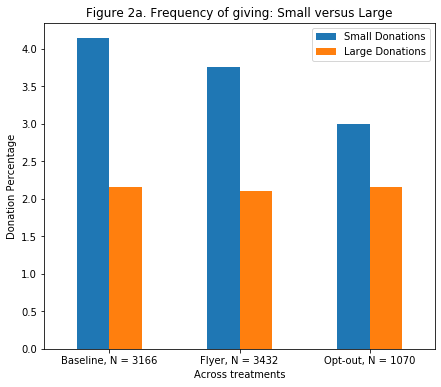

In [195]:
figure5a()
plt.savefig("figure5a.png", bbox_inches='tight')

In [192]:
def figure5b():
    exp = pd.read_stata(r"C:\Users\Lenovo\Desktop\Master_Thesis\CharityOutputQJEFinal.dta")
    exp.drop(columns = ["index"], inplace = True)
    exp["mom"] = "010-10p"

    # Brief Data Cleaning
    exp.loc[(exp["charity"] == "La Rabida") | (exp["charity"] == "LaRabida"), "charity"] = "Lar"
    exp["optout"] = exp["dnd"]
    for x in ["0", 5, 10]:
        for y in [5, 10]:
            for z in ["Nw", "We", "Ooe", "W", "Oo"]:
                exp.loc[exp["treatment"] == f"{z}-{x}d{y}m", "treatment"] = f"{z}{x}d{y}m"
                exp.loc[((exp["treatment"] == f"{z}{x}d{y}m") & ~(z == "Oo")) | (exp["treatment"] == "Nw") | \
                            (exp["treatment"] == "W"), "optout"] = 0
                for yr in ["08", "09"]:
                    exp.loc[(exp["treatment"] == f"{z}{x}d{y}m") & ((x == "0") & (z == "W") & ((y == 5) | (y == 10)) & \
                                                                        (exp["year"] == int(f"{20}{yr}"))), 
                                                                        "treatment"] = f"{z}{x}d{y}m{yr}"

    # Generate dependent variables
    exp.rename(columns={"answer": "outcomeans", "saidyes": "outcomeyes", "optout": "outcomeopt"}, inplace = True)

        
    ## Plot Data for Figure 5b
    list02 = [(len(exp.loc[(exp["treatment"] == c) & ((exp["amt_donate"] > 0) & \
                           (exp["amt_donate"] < 2))]) * 100) / len(exp[exp["treatment"] == c]) for c in ["Nw", "W", "Oo"]]
    list2 = [(len(exp.loc[(exp["treatment"] == c) & \
                          (exp["amt_donate"] == 2)]) * 100)/ len(exp[exp["treatment"] == c]) for c in ["Nw", "W", "Oo"]]
    list25 = [(len(exp.loc[(exp["treatment"] == c) & ((exp["amt_donate"] > 2) & \
                           (exp["amt_donate"] < 5))]) * 100) / len(exp[exp["treatment"] == c]) for c in ["Nw", "W", "Oo"]]
    
    list5 = [(len(exp.loc[(exp["treatment"] == c) & \
                          (exp["amt_donate"] == 5)]) * 100)/ len(exp[exp["treatment"] == c]) for c in ["Nw", "W", "Oo"]]
    list510 = [(len(exp.loc[(exp["treatment"] == c) & ((exp["amt_donate"] > 5) & \
                           (exp["amt_donate"] < 10))]) * 100) / len(exp[exp["treatment"] == c]) for c in ["Nw", "W", "Oo"]]
    list10 = [(len(exp.loc[(exp["treatment"] == c) & \
                          (exp["amt_donate"] == 10)]) * 100)/ len(exp[exp["treatment"] == c]) for c in ["Nw", "W", "Oo"]]
    list1020 = [(len(exp.loc[(exp["treatment"] == c) & ((exp["amt_donate"] > 10) & \
                           (exp["amt_donate"] < 20))]) * 100) / len(exp[exp["treatment"] == c]) for c in ["Nw", "W", "Oo"]]
    list20 = [(len(exp.loc[(exp["treatment"] == c) & \
                          (exp["amt_donate"] == 20)]) * 100)/ len(exp[exp["treatment"] == c]) for c in ["Nw", "W", "Oo"]]
    list2050 = [(len(exp.loc[(exp["treatment"] == c) & ((exp["amt_donate"] > 20) & \
                           (exp["amt_donate"] < 50))]) * 100) / len(exp[exp["treatment"] == c]) for c in ["Nw", "W", "Oo"]]
    list50 = [(len(exp.loc[(exp["treatment"] == c) & \
                          (exp["amt_donate"] == 50)]) * 100)/ len(exp[exp["treatment"] == c]) for c in ["Nw", "W", "Oo"]]
    list50p = [(len(exp.loc[(exp["treatment"] == c) & \
                          (exp["amt_donate"] > 50)]) * 100)/ len(exp[exp["treatment"] == c]) for c in ["Nw", "W", "Oo"]]
    r02 = [round(num, 2) for num in list02]
    r2 = [round(num, 2) for num in list2]
    r25 = [round(num, 2) for num in list25]
    r5 = [round(num, 2) for num in list5]
    r510 = [round(num, 2) for num in list510]
    r10 = [round(num, 2) for num in list10]
    r1020 = [round(num, 2) for num in list1020]
    r20 = [round(num, 2) for num in list20]
    r2050 = [round(num, 2) for num in list2050]
    r50 = [round(num, 2) for num in list50]
    r50p = [round(num, 2) for num in list50p]
    b = [r02[0]]+[r2[0]]+[r25[0]]+[r5[0]]+[r510[0]]+[r10[0]]+[r1020[0]]+[r20[0]]+[r2050[0]]+[r50[0]]+[r50p[0]]
    f = [r02[1]]+[r2[1]]+[r25[1]]+[r5[1]]+[r510[1]]+[r10[1]]+[r1020[1]]+[r20[1]]+[r2050[1]]+[r50[1]]+[r50p[1]]
    o = [r02[2]]+[r2[2]]+[r25[2]]+[r5[2]]+[r510[2]]+[r10[2]]+[r1020[2]]+[r20[2]]+[r2050[2]]+[r50[2]]+[r50p[2]]
    

    N = [(len(exp.loc[(exp["treatment"] == c) & \
                      (exp["amt_donate"] != 0) & \
                      (~exp["amt_donate"].isnull())]) * 100) / len(exp[exp["treatment"] == c]) for c in ["Nw", "W", "Oo"]]
    rn = [round(num, 2) for num in N]
    plotdata = pd.DataFrame({f"Baseline, ({rn[0]} % positive donation)":  b,
                             f"Flyer, ({rn[1]} % positive donation)": f,
                            f"Opt-out, ({rn[2]} % positive donation)": o},
                           index = ["0-2", "2", "2-5", "5", "5-10", "10", "10-20", "20", "20-50", "50", "50+"])
  
    plotdata.plot(kind = "bar")
    plt.xticks(rotation=30, horizontalalignment="center")
    plt.title("Figure 2b. Distribution of Amount Donated Under Different Treatments")
    plt.xlabel("Amount Donated ($)")
    #plt.ylabel("Percentage giving specified amount out of all households")
    plt.rcParams['figure.figsize'] = [7, 6]
    
    return
    
    

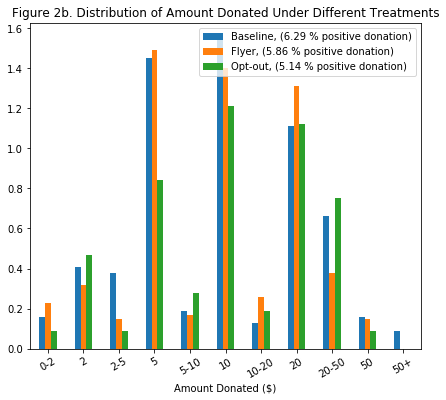

In [193]:
figure5b()
plt.savefig("figure5b.png", bbox_inches='tight')

In [197]:
def figure5a_regression_estimates():
    exp = pd.read_stata(r"C:\Users\Lenovo\Desktop\Master_Thesis\CharityOutputQJEFinal_python.dta")
    exp.drop(columns = ["index"], inplace = True)
    exp["mom"] = "010-10p"

    # Brief Data Cleaning
    exp.loc[(exp["charity"] == "La Rabida") | (exp["charity"] == "LaRabida"), "charity"] = "Lar"
    exp["optout"] = exp["dnd"]
    for x in ["0", 5, 10]:
        for y in [5, 10]:
            for z in ["Nw", "We", "Ooe", "W", "Oo"]:
                exp.loc[exp["treatment"] == f"{z}-{x}d{y}m", "treatment"] = f"{z}{x}d{y}m"
                exp.loc[((exp["treatment"] == f"{z}{x}d{y}m") & ~(z == "Oo")) | (exp["treatment"] == "Nw") | \
                            (exp["treatment"] == "W"), "optout"] = 0
                for yr in ["08", "09"]:
                    exp.loc[(exp["treatment"] == f"{z}{x}d{y}m") & ((x == "0") & (z == "W") & ((y == 5) | (y == 10)) & \
                                                                        (exp["year"] == int(f"{20}{yr}"))), 
                                                                        "treatment"] = f"{z}{x}d{y}m{yr}"

    # Generate dependent variables
    exp.rename(columns={"answer": "outcomeans", "saidyes": "outcomeyes", "optout": "outcomeopt"}, inplace = True)

    ## This set of moments is to do Figure 5
    if exp["mom"].all() =="010-10p":
        exp.loc[(exp["treatment"] == "Nw") | (exp["treatment"] == "Oo") | (exp["treatment"] == "W"), 
                    "outcomedona010"] = ((exp["amt_donate"] > 0) & (exp["amt_donate"] <= 10)) * 1
        exp.loc[(exp["treatment"] == "Nw") | (exp["treatment"] == "Oo") | (exp["treatment"] == "W"), 
                    "outcomedonb10p"] = ((exp["amt_donate"] > 10) & (exp.loc[~exp["amt_donate"].isnull(), "amt_donate"])) * 1
    exp.drop(columns = ['didsurvey', 'hypgivelo', 'hypgivehi', 'yeslarge', 
                   'yessmall', 'yeslarge2', 'yessmall2', 'lamt_donate',
                   'minutes',  'saidyescond', 
                   'charityall',  'month', 'dwave', 'treatmentby', 'amt_donate', 'dnd'], inplace = True)
    
    ### Begin stacked approach
    # Reshape to be able to do calculations of parameters easily
    exp["id"] = range(1, len(exp) + 1)
    exp = pd.melt(exp, id_vars = ["id", "charity", "treatment", "date", "location", 
                                    "year", "mom", "sodate", 'grsol', 'grdatloc',
                                    "grdatlocsol", "grhour", "grarea"],
                           value_name = "outcome")
    exp = exp.sort_values(["id", "variable"])
    exp.rename(columns = {"variable": "outc"}, inplace = True)
    exp.reset_index(inplace = True, drop = True)
    exp["outc"].replace({'outcomeans': 'ans', 'outcomedona010': 'don010',
                        'outcomedonb10p': 'don10p', 'outcomeopt': 'opt', 'outcomeyes': 'yes'}, inplace=True)



    #  Define new dependent variables as dummies
    for z in ["ans", "yes"]:
        for x in ["Nw0d10m", "Nw0d5m", "Nw5d5m", "Oo0d5m", "Oo5d5m",
                      "W0d10m08", "W0d5m08", "W0d10m09", "W0d5m09", "W10d10m", "W10d5m", "W5d5m"]:
            exp[f"tr{z}{x}"] = ((exp["treatment"] == x) & (exp["outc"] == z)) * 1

        for x in ["Nw", "Oo", "W"]:
            for y in ["Ecu", "Lar"]:
                exp[f"tr{z}{x}{y}"] = ((exp["treatment"] == x) & (exp["charity"] == y) & (exp["outc"] == z)) * 1
    for z in ["opt"]:
        for x in ["Oo"]:
            for y in ["Ecu", "Lar"]:
                exp[f"tr{z}{x}{y}"] = ((exp["treatment"] == x) & (exp["charity"] == y) & (exp["outc"] == z)) * 1
        for x in ["Oo0d5m", "Oo5d5m"]:
            exp[f"tr{z}{x}"] = ((exp["treatment"] == x) & (exp["outc"] == z)) * 1 

    for z in ["03", "37", "710", "010", "10", "1020", "2050", "50p", "10p", "02", "2",  "25", "5", "510", "20", "50"]:
        # Here aggregate between ECU and LaRabida to do Figures 5 and 6
        for x in ["Nw", "Oo", "W"]:
            if ((exp["mom"].all() == "all") | (exp["mom"].all() == "010-10p")):
                exp[f"tr{z}{x}"] = ((exp["treatment"] == x) & (exp["outc"] == f"don{z}")) * 1
                if (((exp["mom"].all() =="all") & ((z =="03")| (z=="37")| (z =="710")|  (z =="010")| (z =="10p"))) | \
                        ((exp["mom"].all() =="010-10p") & ~((z =="010")| (z=="10p")))):
                    exp = exp.drop(f"tr{z}{x}", axis = 1)
            elif ((exp["mom"].all() =="010")|(exp["mom"].all() =="010-10")| (exp["mom"].all() =="03-37-710")):
                for y in ["Ecu", "Lar"]:
                    exp[f"tr{z}{x}{y}"] = ((exp["treatment"] == x) & (exp["outc"] == f"don{z}") & \
                                            (exp["charity"] == y)) * 1
                    if (((z =="10p")| (z =="02")|(z =="2")| (z =="25")| (z =="5")| \
                           (z =="510")| (z =="20")| (z =="50")) | \
                           ((exp["mom"].all() =="010") & ((z=="03")| (z =="37")| (z =="710")| (z =="10"))) | \
                           ((exp["mom"].all() =="010-10") & ((z =="03")|(z =="37")|(z =="710"))) | \
                           ((exp["mom"].all() =="03-37-710") & ((z =="010")|(z =="10")))):
                        exp = exp.drop(f"tr{z}{x}{y}", axis = 1)


    #  Keep only outcomes for relevant treatments
    exp = exp.loc[~((exp["outc"]=="opt") & (~((exp["treatment"]=="Oo")|(exp["treatment"]=="Oo0d5m")|\
                                                  (exp["treatment"]=="Oo5d5m"))))]
    exp = exp.loc[~((~((exp["outc"]=="ans")|(exp["outc"]=="yes")|(exp["outc"]=="opt"))) & \
                  (~((exp["treatment"]=="Nw")|(exp["treatment"]=="W")|(exp["treatment"]=="Oo"))))]
    exp.reset_index(inplace= True, drop = True)

    if ((exp["mom"].all() =="all")|(exp["mom"].all() =="010-10p")):
            exp = exp.drop(exp.filter(regex='trans*', axis = 1), axis=1)
            exp = exp.drop(exp.filter(regex='tryes*', axis = 1), axis=1)
            exp = exp.drop(exp.filter(regex='tropt*', axis = 1), axis=1)
            exp = exp.loc[~((exp["outc"] == "ans") | (exp["outc"] == "opt") | (exp["outc"] == "yes"))]

    exp.loc[exp["charity"] == "Sv2008", "sv"] = "sv08"
    exp.loc[exp["charity"] == "Sv2009", "sv"] =  "sv09"
    exp["outcsv"] = exp.loc[~exp["outc"].isnull(), "outc"].astype("str") + exp.loc[~exp["sv"].isnull(), "sv"].astype("str") 
    exp.loc[exp["sv"].isnull(), "outcsv"] = exp["outc"]
    
    ############# For plotting ###########
    N = [len(exp[exp["treatment"] == c]) for c in ["Nw", "W", "Oo"]]
    ######################################
    exp = exp.drop(["location", "charity", "treatment", "date", "sv"], axis = 1)

    # Change the order of variables
    if exp["mom"].all() == "010-10p":
        exp = exp[["id", "year", "mom", "sodate", 'grsol', 'grdatloc',
                       "grdatlocsol", "grhour", "grarea", "outc", "outcsv", "outcome",
                      "tr010Nw", "tr010Oo", "tr010W", "tr10pNw", "tr10pOo", "tr10pW"]]
    ### Moments and VC matrix without controls
    string = f"outcome ~ {exp.columns[12]}"
    for i in exp.columns[13:].to_list():
        string += f" + {i}"
    string += "- 1"
    model = ols(string, data=exp)
    fitted_model = model.fit(cov_type="cluster", cov_kwds={"groups": exp["sodate"]})
    f = []
    f1 = []
    for x in exp.columns[12:]:
        f.append(fitted_model.params.loc[[x]][0])
        if fitted_model.pvalues.loc[[x]][0].round(5) <= 0.01:
            bse = fitted_model.bse.loc[[x]][0]
            f1.append(f"({round(bse, 4)})***")
        elif fitted_model.pvalues.loc[[x]][0].round(5) <= 0.05:
            bse = fitted_model.bse.loc[[x]][0]
            f1.append(f"({round(bse, 4)})**")

        elif fitted_model.pvalues.loc[[x]][0].round(5) <= 0.1:    
            bse = fitted_model.bse.loc[[x]][0]
            f1.append(f"({round(bse, 4)})*")
        else:
            bse = fitted_model.bse.loc[[x]][0]
            f1.append(f"({round(bse, 4)})")
    df_model = pd.DataFrame({"Coefficients": f, "Std Errors": f1}, index = exp.columns[12:].to_list())
    df_model.index.name = "Variables/Moments"
    df_model = df_model.round(5)
    
    # Plot Data for Figure 5a with regression estimates results:
    plotdata = pd.DataFrame(data = {"Small Donations": ((df_model.iloc[0:3,0]) * 100).to_list(), 
                                    "Large Donations": ((df_model.iloc[3:,0]) * 100).to_list()},
                           index = [f"Baseline, N = {N[0]/2}", f"Flyer, N = {N[1]/2}", f"Flyer with Opt-out, N = {N[2]/2}"])
    plotdata.plot(kind = "bar")
    plt.xticks(rotation=0, horizontalalignment="center")
    plt.title("Figure 2a. Frequency of giving: Small versus Large, using estimated moments")
    plt.xlabel("Across treatments")
    plt.ylabel("Donation Percentage")
    plt.rcParams['figure.figsize'] = [7, 6]
    return 

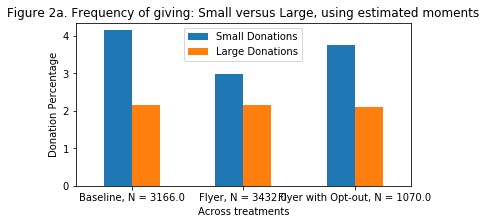

In [198]:
figure5a_regression_estimates()
plt.savefig("figure5aa.png", bbox_inches='tight')

In [ ]:
 ######################################################   Moments 010-10  #################################################

In [477]:
exp = pd.read_stata(r"C:\Users\Lenovo\Desktop\Master_Thesis\CharityOutputQJEFinal_python.dta")
exp.drop(columns = ["index"], inplace = True)
exp["mom"] = "010-10"
    
# Brief Data Cleaning
exp.loc[(exp["charity"] == "La Rabida") | (exp["charity"] == "LaRabida"), "charity"] = "Lar"
exp["optout"] = exp["dnd"]
for x in ["0", 5, 10]:
    for y in [5, 10]:
        for z in ["Nw", "We", "Ooe", "W", "Oo"]:
            exp.loc[exp["treatment"] == f"{z}-{x}d{y}m", "treatment"] = f"{z}{x}d{y}m"
            exp.loc[((exp["treatment"] == f"{z}{x}d{y}m") & ~(z == "Oo")) | (exp["treatment"] == "Nw") | \
                        (exp["treatment"] == "W"), "optout"] = 0
            for yr in ["08", "09"]:
                exp.loc[(exp["treatment"] == f"{z}{x}d{y}m") & ((x == "0") & (z == "W") & ((y == 5) | (y == 10)) & \
                                                                    (exp["year"] == int(f"{20}{yr}"))), 
                                                                    "treatment"] = f"{z}{x}d{y}m{yr}"
                    
# Generate dependent variables
exp.rename(columns={"answer": "outcomeans", "saidyes": "outcomeyes", "optout": "outcomeopt"}, inplace = True)

## Benchmark set of moments
## Use for Figures 4 and 7
if exp["mom"].all() =="010-10":
    exp.loc[(exp["treatment"] == "Nw") | (exp["treatment"] == "Oo") | (exp["treatment"] == "W"), 
                "outcomedona010"] = ((exp["amt_donate"] > 0) & (exp["amt_donate"] < 10)) * 1
    exp.loc[(exp["treatment"] == "Nw") | (exp["treatment"] == "Oo") | (exp["treatment"] == "W"), 
                "outcomedonb10"] = (exp["amt_donate"] == 10) * 1
    exp.loc[(exp["treatment"] == "Nw") | (exp["treatment"] == "Oo") | (exp["treatment"] == "W"), 
                "outcomedonc1020"] = ((exp["amt_donate"] > 10) & (exp["amt_donate"] <= 20)) * 1
    exp.loc[(exp["treatment"] == "Nw") | (exp["treatment"] == "Oo") | (exp["treatment"] == "W"), 
                "outcomedond2050"] = ((exp["amt_donate"] > 20) & (exp["amt_donate"] <= 50)) * 1
    exp.loc[(exp["treatment"] == "Nw") | (exp["treatment"] == "Oo") | (exp["treatment"] == "W"), 
                "outcomedone50p"] = ((exp["amt_donate"] > 50) & (exp.loc[~exp["amt_donate"].isnull(), "amt_donate"])) * 1

        
   
        
        
    
exp.drop(columns = ['didsurvey', 'hypgivelo', 'hypgivehi', 'yeslarge', 
                   'yessmall', 'yeslarge2', 'yessmall2', 'lamt_donate',
                   'minutes',  'saidyescond', 
                   'charityall',  'month', 'dwave', 'treatmentby', 'amt_donate', 'dnd'], inplace = True)
    
### Begin stacked approach
# Reshape to be able to do calculations of parameters easily
exp["id"] = range(1, len(exp) + 1)
exp = pd.melt(exp, id_vars = ["id", "charity", "treatment", "date", "location", 
                                "year", "mom", "sodate", 'grsol', 'grdatloc',
                                "grdatlocsol", "grhour", "grarea"],
                       value_name = "outcome")
exp = exp.sort_values(["id", "variable"])
exp.rename(columns = {"variable": "outc"}, inplace = True)
exp.reset_index(inplace = True, drop = True)
 
exp["outc"].replace({'outcomeans': 'ans', "outcomedona010": 'don010',
                    "outcomedonb10": 'don10', "outcomedonc1020": "don1020", "outcomedond2050": "don2050", 
                     "outcomedone50p": "don50p", 'outcomeopt': 'opt', 'outcomeyes': 'yes'}, inplace=True)
   
#  Define new dependent variables as dummies
for z in ["ans", "yes"]:
    for x in ["Nw0d10m", "Nw0d5m", "Nw5d5m", "Oo0d5m", "Oo5d5m",
                  "W0d10m08", "W0d5m08", "W0d10m09", "W0d5m09", "W10d10m", "W10d5m", "W5d5m"]:
        exp[f"tr{z}{x}"] = ((exp["treatment"] == x) & (exp["outc"] == z)) * 1
            
    for x in ["Nw", "Oo", "W"]:
        for y in ["Ecu", "Lar"]:
            exp[f"tr{z}{x}{y}"] = ((exp["treatment"] == x) & (exp["charity"] == y) & (exp["outc"] == z)) * 1
for z in ["opt"]:
    for x in ["Oo"]:
        for y in ["Ecu", "Lar"]:
            exp[f"tr{z}{x}{y}"] = ((exp["treatment"] == x) & (exp["charity"] == y) & (exp["outc"] == z)) * 1
    for x in ["Oo0d5m", "Oo5d5m"]:
        exp[f"tr{z}{x}"] = ((exp["treatment"] == x) & (exp["outc"] == z)) * 1 
    
for z in ["03", "37", "710", "010", "10", "1020", "2050", "50p", "10p", "02", "2",  "25", "5", "510", "20", "50"]:
    # Here aggregate between ECU and LaRabida to do Figures 5 and 6
    for x in ["Nw", "Oo", "W"]:
        if ((exp["mom"].all() == "all") | (exp["mom"].all() == "010-10p")):
            exp[f"tr{z}{x}"] = ((exp["treatment"] == x) & (exp["outc"] == f"don{z}")) * 1
            if (((exp["mom"].all() =="all") & ((z =="03")| (z=="37")| (z =="710")|  (z =="010")| (z =="10p"))) | \
                    ((exp["mom"].all() =="010-10p") & ~((z =="010")| (z=="10p")))):
                    exp = exp.drop(f"tr{z}{x}", axis = 1)
        elif ((exp["mom"].all() =="010")|(exp["mom"].all() =="010-10")| (exp["mom"].all() =="03-37-710")):
            for y in ["Ecu", "Lar"]:
                exp[f"tr{z}{x}{y}"] = ((exp["treatment"] == x) & (exp["outc"] == f"don{z}") & \
                                        (exp["charity"] == y)) * 1
                if (((z =="10p")| (z =="02")|(z =="2")| (z =="25")| (z =="5")| \
                       (z =="510")| (z =="20")| (z =="50")) | \
                       ((exp["mom"].all() =="010") & ((z=="03")| (z =="37")| (z =="710")| (z =="10"))) | \
                       ((exp["mom"].all() =="010-10") & ((z =="03")|(z =="37")|(z =="710"))) | \
                       ((exp["mom"].all() =="03-37-710") & ((z =="010")|(z =="10")))):
                    exp = exp.drop(f"tr{z}{x}{y}", axis = 1)

                          
#  Keep only outcomes for relevant treatments
exp = exp.loc[~((exp["outc"]=="opt") & (~((exp["treatment"]=="Oo")|(exp["treatment"]=="Oo0d5m")|\
                                              (exp["treatment"]=="Oo5d5m"))))]
exp = exp.loc[~((~((exp["outc"]=="ans")|(exp["outc"]=="yes")|(exp["outc"]=="opt"))) & \
              (~((exp["treatment"]=="Nw")|(exp["treatment"]=="W")|(exp["treatment"]=="Oo"))))]
exp.reset_index(inplace= True, drop = True)
    
if ((exp["mom"].all() =="all")|(exp["mom"].all() =="010-10p")):
    exp = exp.drop(exp.filter(regex='trans*', axis = 1), axis=1)
    exp = exp.drop(exp.filter(regex='tryes*', axis = 1), axis=1)
    exp = exp.drop(exp.filter(regex='tropt*', axis = 1), axis=1)
    exp = exp.loc[~((exp["outc"] == "ans") | (exp["outc"] == "opt") | (exp["outc"] == "yes"))]
        
exp.loc[exp["charity"] == "Sv2008", "sv"] = "sv08"
exp.loc[exp["charity"] == "Sv2009", "sv"] =  "sv09"
exp["outcsv"] = exp.loc[~exp["outc"].isnull(), "outc"].astype("str") + exp.loc[~exp["sv"].isnull(), "sv"].astype("str") 
exp.loc[exp["sv"].isnull(), "outcsv"] = exp["outc"]
exp = exp.drop(["location", "charity", "treatment", "date", "sv"], axis = 1)
    
# Change the order of variables
exp = exp[["id", "year", "mom", "sodate", 'grsol', 'grdatloc',
                   "grdatlocsol", "grhour", "grarea", "outc", "outcsv", "outcome",
                   "transNwLar", "transNwEcu", "transWLar", "transWEcu", "transOoLar", "transOoEcu",
                   "transNw0d10m", "transW0d5m08", "transW0d10m08", "transW10d10m", 
                   "tryesNwLar", "tryesNwEcu", "tryesWLar", "tryesWEcu", "tryesOoLar", "tryesOoEcu", 
                   "tryesNw0d10m", "tryesW0d5m08", "tryesW0d10m08", "tryesW10d10m", "troptOoLar", "troptOoEcu",
                   "transNw0d5m", "transNw5d5m", "transOo0d5m", "transOo5d5m", "transW0d10m09", 
                   "transW0d5m09", "transW10d5m", "transW5d5m", "tryesNw0d5m", "tryesNw5d5m", "tryesOo0d5m",
                   "tryesOo5d5m", "tryesW0d10m09", "tryesW0d5m09", "tryesW10d5m", "tryesW5d5m",
                   "troptOo0d5m", "troptOo5d5m", "tr010NwEcu", "tr010NwLar", "tr010OoEcu", "tr010OoLar",
                   "tr010WEcu", "tr010WLar", "tr10NwEcu", "tr10NwLar", "tr10OoEcu", "tr10OoLar", "tr10WEcu", "tr10WLar", 
                   "tr1020NwEcu", "tr1020NwLar", "tr1020OoEcu", "tr1020OoLar", "tr1020WEcu", "tr1020WLar", "tr2050NwEcu", 
                   "tr2050NwLar", "tr2050OoEcu", "tr2050OoLar", "tr2050WEcu", "tr2050WLar",
                   "tr50pNwEcu", "tr50pNwLar", "tr50pOoEcu", "tr50pOoLar", "tr50pWEcu", "tr50pWLar"]]

    
                   
        
### Moments and VC matrix without controls
string = f"outcome ~ {exp.columns[12]}"
for i in exp.columns[13:].to_list():
    string += f" + {i}"
string += "- 1"
model = ols(string, data=exp)
fitted_model = model.fit(cov_type="cluster", cov_kwds={"groups": exp["sodate"]})
f = []
f1 = []
for x in exp.columns[12:]:
    f.append(fitted_model.params.loc[[x]][0])
    if fitted_model.pvalues.loc[[x]][0].round(5) <= 0.01:
        bse = fitted_model.bse.loc[[x]][0]
        f1.append(f"({round(bse, 4)})***")
    elif fitted_model.pvalues.loc[[x]][0].round(5) <= 0.05:
        bse = fitted_model.bse.loc[[x]][0]
        f1.append(f"({round(bse, 4)})**")

    elif fitted_model.pvalues.loc[[x]][0].round(5) <= 0.1:    
        bse = fitted_model.bse.loc[[x]][0]
        f1.append(f"({round(bse, 4)})*")
    else:
        bse = fitted_model.bse.loc[[x]][0]
        f1.append(f"({round(bse, 4)})")
df_model = pd.DataFrame({"Coefficients": f, "Std Errors": f1}, index = exp.columns[12:].to_list())
df_model.index.name = "Variables/Moments"
df_model = df_model.round(5)
df_model.to_csv(r"C:\Users\Lenovo\Desktop\Master_Thesis\reduced_form\output\moments010-10.csv")

exp.to_stata(r"C:\Users\Lenovo\Desktop\Master_Thesis\reduced_form\regs\cleanShortQJE_010-10.dta")
exp = pd.read_stata(r"C:\Users\Lenovo\Desktop\Master_Thesis\reduced_form\regs\cleanShortQJE_010-10.dta")
exp.drop(columns = ["index"], inplace = True)


    
    
    

In [480]:
###  Demeaning the control variables to get the moments evaluated at the mean value of the parameters
j = {"sol": exp["grsol"].max(), "datloc": exp["grdatloc"].max(),
    "hour": exp["grhour"].max(), "area": exp["grarea"].max()}
for x in ["sol", "datloc", "hour", "area"]:
    for i in range(1, j[x] + 1):
        exp[f"gr{x}{i}"] = (exp[f"gr{x}"] == i) * 1 
        if ((exp["mom"].all() == "010-10p") | (exp["mom"].all() == "all")):
            l1 = ["don03", "don37", "don710", "don010", "don10", "don1020", "don2050", "don50p", 
                  "don10p", "don02", "don2", "don25", "don5", "don510", "don20", "don50"]
            for z in l1:
                a1 = (((exp["mom"].all() =="all") & ~((z=="don03")|(z=="don37")|(z=="don710")|(z=="don010")|(z=="don10p"))) | \
                   ((exp["mom"].all() =="010-10p") & ((z=="don010")|(z=="don10p"))))
                if a1:
                    exp[f"gr{z}{x}{i}"] = np.logical_and(exp[f"gr{x}"].to_numpy() == i, 
                                       exp["outcsv"].to_numpy() == z).astype(np.uint8)
                    exp[f"mgr{z}{x}{i}"] = np.mean(exp[f"gr{z}{x}{i}"][exp["outcsv"] == z].to_numpy(),
                                                        dtype = "int32") 
                    exp[f"dgr{z}{x}{i}"] = np.where(exp[f"mgr{z}{x}{i}"].isnull().to_numpy(), 0,
                                np.subtract(exp[f"gr{z}{x}{i}"].to_numpy(), exp[f"mgr{z}{x}{i}"].to_numpy()))
                    exp = exp.drop([f"gr{z}{x}{i}", f"mgr{z}{x}{i}"], axis = 1)


        elif ((exp["mom"].all() == "010") | (exp["mom"].all() == "010-10") | (exp["mom"].all() == "03-37-710")):
            l = ["ans", "anssv08", "anssv09", "opt", "optsv09", "yes", "yessv08", "yessv09", "don03", "don37", 
                      "don710",  "don010", "don10", "don1020", "don2050", "don50p", "don10p", "don02", "don2",
                   "don25", "don5", "don510", "don20", "don50"] 
            for z in l:
                a = (((z=="ans")|(z=="anssv08")|(z=="anssv09")|(z=="opt")|(z=="optsv09")|(z=="yes")|(z=="yessv08") | \
                    (z=="yessv09")) | ((exp["mom"].all()=="010") & ((z=="don010")|(z=="don1020")|(z=="don2050")|(z=="don50p"))) | \
                   ((exp["mom"].all()=="010-10") & ((z=="don010")|(z=="don10")|(z=="don1020")| \
                    (z=="don2050")|(z=="don50p"))) | ((exp["mom"].all()=="03-37-710") & \
                    ((z=="don03")|(z=="don37")|(z=="don710")|(z=="don1020")|(z=="don2050")|(z=="don50p"))))
                if a:
                    exp[f"gr{z}{x}{i}"] = np.logical_and(exp[f"gr{x}"].to_numpy() == i, 
                                       exp["outcsv"].to_numpy() == z).astype(np.uint8)
                    exp[f"mgr{z}{x}{i}"] = np.mean(exp[f"gr{z}{x}{i}"][exp["outcsv"] == z].to_numpy(),
                                                        dtype = "int32") 
                    exp[f"dgr{z}{x}{i}"] = np.where(exp[f"mgr{z}{x}{i}"].isnull().to_numpy(), 0,
                                np.subtract(exp[f"gr{z}{x}{i}"].to_numpy(), exp[f"mgr{z}{x}{i}"].to_numpy()))
                    exp = exp.drop([f"gr{z}{x}{i}", f"mgr{z}{x}{i}"], axis = 1)


In [204]:
#exp.to_stata(r"C:\Users\Lenovo\Desktop\Master_Thesis\reduced_form\regs\cleanShortQJE_010-10_DemeanedReg.dta")
exp = pd.read_stata(r"C:\Users\Lenovo\Desktop\Master_Thesis\reduced_form\regs\cleanShortQJE_010-10_DemeanedReg.dta") 
exp.drop(columns = ["index"], inplace = True)

In [205]:
def regress_estimates_for_figure4():
    exp = pd.read_stata(r"C:\Users\Lenovo\Desktop\Master_Thesis\CharityOutputQJEFinal_python.dta")
    exp.drop(columns = ["index"], inplace = True)
    exp["mom"] = "010-10"

    # Brief Data Cleaning
    exp.loc[(exp["charity"] == "La Rabida") | (exp["charity"] == "LaRabida"), "charity"] = "Lar"
    exp["optout"] = exp["dnd"]
    for x in ["0", 5, 10]:
        for y in [5, 10]:
            for z in ["Nw", "We", "Ooe", "W", "Oo"]:
                exp.loc[exp["treatment"] == f"{z}-{x}d{y}m", "treatment"] = f"{z}{x}d{y}m"
                exp.loc[((exp["treatment"] == f"{z}{x}d{y}m") & ~(z == "Oo")) | (exp["treatment"] == "Nw") | \
                            (exp["treatment"] == "W"), "optout"] = 0
                for yr in ["08", "09"]:
                    exp.loc[(exp["treatment"] == f"{z}{x}d{y}m") & ((x == "0") & (z == "W") & ((y == 5) | (y == 10)) & \
                                                                        (exp["year"] == int(f"{20}{yr}"))), 
                                                                        "treatment"] = f"{z}{x}d{y}m{yr}"

    # Generate dependent variables
    exp.rename(columns={"answer": "outcomeans", "saidyes": "outcomeyes", "optout": "outcomeopt"}, inplace = True)

    ## Benchmark set of moments
    ## Use for Figures 4 and 7
    if exp["mom"].all() =="010-10":
        exp.loc[(exp["treatment"] == "Nw") | (exp["treatment"] == "Oo") | (exp["treatment"] == "W"), 
                    "outcomedona010"] = ((exp["amt_donate"] > 0) & (exp["amt_donate"] < 10)) * 1
        exp.loc[(exp["treatment"] == "Nw") | (exp["treatment"] == "Oo") | (exp["treatment"] == "W"), 
                    "outcomedonb10"] = (exp["amt_donate"] == 10) * 1
        exp.loc[(exp["treatment"] == "Nw") | (exp["treatment"] == "Oo") | (exp["treatment"] == "W"), 
                    "outcomedonc1020"] = ((exp["amt_donate"] > 10) & (exp["amt_donate"] <= 20)) * 1
        exp.loc[(exp["treatment"] == "Nw") | (exp["treatment"] == "Oo") | (exp["treatment"] == "W"), 
                    "outcomedond2050"] = ((exp["amt_donate"] > 20) & (exp["amt_donate"] <= 50)) * 1
        exp.loc[(exp["treatment"] == "Nw") | (exp["treatment"] == "Oo") | (exp["treatment"] == "W"), 
                    "outcomedone50p"] = ((exp["amt_donate"] > 50) & (exp.loc[~exp["amt_donate"].isnull(), "amt_donate"])) * 1






    exp.drop(columns = ['didsurvey', 'hypgivelo', 'hypgivehi', 'yeslarge', 
                       'yessmall', 'yeslarge2', 'yessmall2', 'lamt_donate',
                       'minutes',  'saidyescond', 
                       'charityall',  'month', 'dwave', 'treatmentby', 'amt_donate', 'dnd'], inplace = True)
    

    ### Begin stacked approach
    # Reshape to be able to do calculations of parameters easily
    exp["id"] = range(1, len(exp) + 1)
    exp = pd.melt(exp, id_vars = ["id", "charity", "treatment", "date", "location", 
                                    "year", "mom", "sodate", 'grsol', 'grdatloc',
                                    "grdatlocsol", "grhour", "grarea"],
                           value_name = "outcome")
    exp = exp.sort_values(["id", "variable"])
    exp.rename(columns = {"variable": "outc"}, inplace = True)
    exp.reset_index(inplace = True, drop = True)

    exp["outc"].replace({'outcomeans': 'ans', "outcomedona010": 'don010',
                        "outcomedonb10": 'don10', "outcomedonc1020": "don1020", "outcomedond2050": "don2050", 
                         "outcomedone50p": "don50p", 'outcomeopt': 'opt', 'outcomeyes': 'yes'}, inplace=True)

    #  Define new dependent variables as dummies
    for z in ["ans", "yes"]:
        for x in ["Nw0d10m", "Nw0d5m", "Nw5d5m", "Oo0d5m", "Oo5d5m",
                      "W0d10m08", "W0d5m08", "W0d10m09", "W0d5m09", "W10d10m", "W10d5m", "W5d5m"]:
            exp[f"tr{z}{x}"] = ((exp["treatment"] == x) & (exp["outc"] == z)) * 1

        for x in ["Nw", "Oo", "W"]:
            for y in ["Ecu", "Lar"]:
                exp[f"tr{z}{x}{y}"] = ((exp["treatment"] == x) & (exp["charity"] == y) & (exp["outc"] == z)) * 1
    for z in ["opt"]:
        for x in ["Oo"]:
            for y in ["Ecu", "Lar"]:
                exp[f"tr{z}{x}{y}"] = ((exp["treatment"] == x) & (exp["charity"] == y) & (exp["outc"] == z)) * 1
        for x in ["Oo0d5m", "Oo5d5m"]:
            exp[f"tr{z}{x}"] = ((exp["treatment"] == x) & (exp["outc"] == z)) * 1 

    for z in ["03", "37", "710", "010", "10", "1020", "2050", "50p", "10p", "02", "2",  "25", "5", "510", "20", "50"]:
        # Here aggregate between ECU and LaRabida to do Figures 5 and 6
        for x in ["Nw", "Oo", "W"]:
            if ((exp["mom"].all() == "all") | (exp["mom"].all() == "010-10p")):
                exp[f"tr{z}{x}"] = ((exp["treatment"] == x) & (exp["outc"] == f"don{z}")) * 1
                if (((exp["mom"].all() =="all") & ((z =="03")| (z=="37")| (z =="710")|  (z =="010")| (z =="10p"))) | \
                        ((exp["mom"].all() =="010-10p") & ~((z =="010")| (z=="10p")))):
                        exp = exp.drop(f"tr{z}{x}", axis = 1)
            elif ((exp["mom"].all() =="010")|(exp["mom"].all() =="010-10")| (exp["mom"].all() =="03-37-710")):
                for y in ["Ecu", "Lar"]:
                    exp[f"tr{z}{x}{y}"] = ((exp["treatment"] == x) & (exp["outc"] == f"don{z}") & \
                                            (exp["charity"] == y)) * 1
                    if (((z =="10p")| (z =="02")|(z =="2")| (z =="25")| (z =="5")| \
                           (z =="510")| (z =="20")| (z =="50")) | \
                           ((exp["mom"].all() =="010") & ((z=="03")| (z =="37")| (z =="710")| (z =="10"))) | \
                           ((exp["mom"].all() =="010-10") & ((z =="03")|(z =="37")|(z =="710"))) | \
                           ((exp["mom"].all() =="03-37-710") & ((z =="010")|(z =="10")))):
                        exp = exp.drop(f"tr{z}{x}{y}", axis = 1)


    #  Keep only outcomes for relevant treatments
    exp = exp.loc[~((exp["outc"]=="opt") & (~((exp["treatment"]=="Oo")|(exp["treatment"]=="Oo0d5m")|\
                                                  (exp["treatment"]=="Oo5d5m"))))]
    exp = exp.loc[~((~((exp["outc"]=="ans")|(exp["outc"]=="yes")|(exp["outc"]=="opt"))) & \
                  (~((exp["treatment"]=="Nw")|(exp["treatment"]=="W")|(exp["treatment"]=="Oo"))))]
    exp.reset_index(inplace= True, drop = True)

    if ((exp["mom"].all() =="all")|(exp["mom"].all() =="010-10p")):
        exp = exp.drop(exp.filter(regex='trans*', axis = 1), axis=1)
        exp = exp.drop(exp.filter(regex='tryes*', axis = 1), axis=1)
        exp = exp.drop(exp.filter(regex='tropt*', axis = 1), axis=1)
        exp = exp.loc[~((exp["outc"] == "ans") | (exp["outc"] == "opt") | (exp["outc"] == "yes"))]

    exp.loc[exp["charity"] == "Sv2008", "sv"] = "sv08"
    exp.loc[exp["charity"] == "Sv2009", "sv"] =  "sv09"
    exp["outcsv"] = exp.loc[~exp["outc"].isnull(), "outc"].astype("str") + exp.loc[~exp["sv"].isnull(), "sv"].astype("str") 
    exp.loc[exp["sv"].isnull(), "outcsv"] = exp["outc"]
    

    exp = exp.drop(["location", "charity", "treatment", "date", "sv"], axis = 1)

    # Change the order of variables
    exp = exp[["id", "year", "mom", "sodate", 'grsol', 'grdatloc',
                       "grdatlocsol", "grhour", "grarea", "outc", "outcsv", "outcome",
                       "transNwLar", "transNwEcu", "transWLar", "transWEcu", "transOoLar", "transOoEcu",
                       "transNw0d10m", "transW0d5m08", "transW0d10m08", "transW10d10m", 
                       "tryesNwLar", "tryesNwEcu", "tryesWLar", "tryesWEcu", "tryesOoLar", "tryesOoEcu", 
                       "tryesNw0d10m", "tryesW0d5m08", "tryesW0d10m08", "tryesW10d10m", "troptOoLar", "troptOoEcu",
                       "transNw0d5m", "transNw5d5m", "transOo0d5m", "transOo5d5m", "transW0d10m09", 
                       "transW0d5m09", "transW10d5m", "transW5d5m", "tryesNw0d5m", "tryesNw5d5m", "tryesOo0d5m",
                       "tryesOo5d5m", "tryesW0d10m09", "tryesW0d5m09", "tryesW10d5m", "tryesW5d5m",
                       "troptOo0d5m", "troptOo5d5m", "tr010NwEcu", "tr010NwLar", "tr010OoEcu", "tr010OoLar",
                       "tr010WEcu", "tr010WLar", "tr10NwEcu", "tr10NwLar", "tr10OoEcu", "tr10OoLar", "tr10WEcu", "tr10WLar", 
                       "tr1020NwEcu", "tr1020NwLar", "tr1020OoEcu", "tr1020OoLar", "tr1020WEcu", "tr1020WLar", "tr2050NwEcu", 
                       "tr2050NwLar", "tr2050OoEcu", "tr2050OoLar", "tr2050WEcu", "tr2050WLar",
                       "tr50pNwEcu", "tr50pNwLar", "tr50pOoEcu", "tr50pOoLar", "tr50pWEcu", "tr50pWLar"]]




    ### Moments and VC matrix without controls
    string = f"outcome ~ {exp.columns[12]}"
    for i in exp.columns[13:].to_list():
        string += f" + {i}"
    string += "- 1"
    model = ols(string, data=exp)
    fitted_model = model.fit(cov_type="cluster", cov_kwds={"groups": exp["sodate"]})
    f = []
    f1 = []
    for x in exp.columns[12:]:
        f.append(fitted_model.params.loc[[x]][0])
        if fitted_model.pvalues.loc[[x]][0].round(5) <= 0.01:
            bse = fitted_model.bse.loc[[x]][0]
            f1.append(f"({round(bse, 4)})***")
        elif fitted_model.pvalues.loc[[x]][0].round(5) <= 0.05:
            bse = fitted_model.bse.loc[[x]][0]
            f1.append(f"({round(bse, 4)})**")

        elif fitted_model.pvalues.loc[[x]][0].round(5) <= 0.1:    
            bse = fitted_model.bse.loc[[x]][0]
            f1.append(f"({round(bse, 4)})*")
        else:
            bse = fitted_model.bse.loc[[x]][0]
            f1.append(f"({round(bse, 4)})")
    df_model = pd.DataFrame({"Coefficients": f, "Std Errors": f1}, index = exp.columns[12:].to_list())
    df_model.index.name = "Variables/Moments"
    df_model = df_model.round(5)
    
    return df_model
    
    

In [235]:
df_model = regress_estimates_for_figure4()

In [217]:
def figure4a_regression_estimates():
    #df_model = regress_estimates_for_figure4()
    # Plotting the data for figure 4a
    lar = [df_model.iloc[0, 0]] + [df_model.iloc[2, 0]] + [df_model.iloc[4, 0]] + [df_model.iloc[20,0]]
    ecu = [df_model.iloc[1, 0]] + [df_model.iloc[3, 0]] + [df_model.iloc[5, 0]] + [df_model.iloc[21,0]]
    n = [len(exp[exp[item] == 1]) for item in ["transNwLar", "transNwEcu", "transWLar", 
                                                       "transWEcu", "transOoLar", "transOoEcu", 
                                                       "troptOoLar", "troptOoEcu"]]
    
    plotdata = pd.DataFrame(data = {"La Rabida Children's Hospital": list(np.array(lar)*100),
                                   "Center for Natural Hazards Mitigation Research (ECU)": list(np.array(ecu)*100)},
                           index = ["Baseline",
                                   "Flyer",
                                   "Opt-Out",
                                   "Opt-out to answer"])
    plotdata.plot(kind = "bar")
    plt.xticks(rotation=0, horizontalalignment="center")
    plt.title("Figure 1a. Frequency of Answering the Door, Using Estimated Moments")
    plt.xlabel("Across treatments")
    plt.ylabel("Percentage")
    plt.rcParams['figure.figsize'] = [6, 6]
    return 
    
    



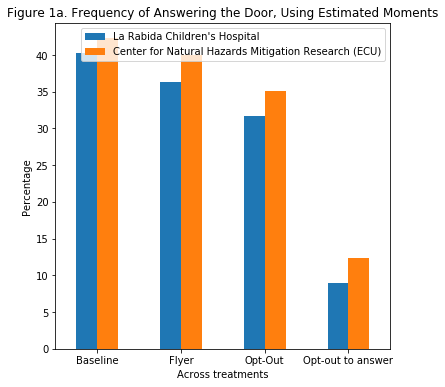

In [218]:
figure4a_regression_estimates()
plt.savefig("figure4a.png")

In [223]:
def figure4b_regression_estimates():
    #df_model = regress_estimates_for_figure4()
    # Plot data for figure 4b
    lar = [df_model.iloc[10, 0]] + [df_model.iloc[12, 0]] + [df_model.iloc[14, 0]]
    ecu = [df_model.iloc[11, 0]] + [df_model.iloc[13, 0]] + [df_model.iloc[15,0]]
    n = [len(exp[exp[item] == 1]) for item in ["tryesNwLar", "tryesNwEcu", "tryesWLar", 
                                                       "tryesWEcu", "tryesOoLar", "tryesOoEcu"]]
    
    plotdata = pd.DataFrame(data = {"La Rabida Children's Hospital": list(np.array(lar)*100),
                                   "Center for Natural Hazards Mitigation Research (ECU)": list(np.array(ecu)*100)},
                           index = ["Baseline",
                                    "Flyer",
                                   "Opt-Out"])
    plotdata.plot(kind = "bar")
    plt.xticks(rotation=0, horizontalalignment="center")
    plt.title("Figure 1b. Frequency of Unconditional Giving, Using Estimated Moments")
    plt.xlabel("Across treatments")
    plt.ylabel("Percentage")
    plt.rcParams['figure.figsize'] = [7, 6]
    
    return

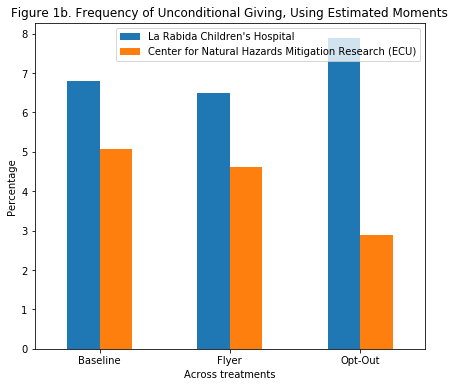

In [224]:
figure4b_regression_estimates()
plt.savefig("figure4b.png")

In [225]:
def figure4c_regression_estimates():
    #df_model = regress_estimates_for_figure4()
    # Plot data for figure 4b
    lar = [df_model.iloc[10, 0] / df_model.iloc[0, 0]] + [df_model.iloc[12, 0] / df_model.iloc[2, 0]] +\
          [df_model.iloc[14, 0] / df_model.iloc[4, 0]]
    ecu = [df_model.iloc[11, 0] / df_model.iloc[1, 0]] + [df_model.iloc[13, 0] / df_model.iloc[3, 0]] +\
          [df_model.iloc[15, 0] / df_model.iloc[5, 0]]
    n = [len(exp[exp[item] == 1]) for item in ["tryesNwLar", "tryesNwEcu", "tryesWLar", 
                                                       "tryesWEcu", "tryesOoLar", "tryesOoEcu"]]
    
    plotdata = pd.DataFrame(data = {"La Rabida Children's Hospital": list(np.array(lar)*100),
                                   "Center for Natural Hazards Mitigation Research (ECU)": list(np.array(ecu)*100)},
                           index = ["Baseline",
                                    "Flyer",
                                    "Flyer with Opt-Out"])
    plotdata.plot(kind = "bar")
    plt.xticks(rotation=0, horizontalalignment="center")
    plt.title("Figure 1c. Frequency of Unconditional Giving Conditional on Answering the Door, Using Estimated Moments")
    plt.xlabel("Across treatments")
    plt.ylabel("Percentage")
    plt.rcParams['figure.figsize'] = [7, 6]
    
    return
    

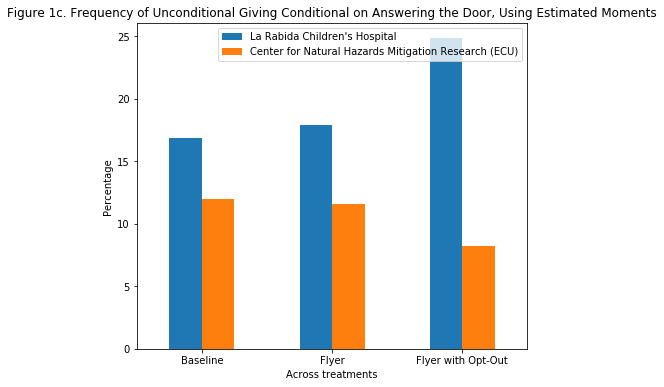

In [226]:
figure4c_regression_estimates()
plt.savefig("figure4c.png")

In [ ]:
##################################################### Moments - all ##################################################

In [236]:
def figure6a_regression_estimates():
    #df_model = regress_estimates_for_figure4()
    df_model.reset_index(inplace = True)
    # Plot data for figure 6a
    ans = [df_model[df_model["Variables/Moments"] == 'transNw0d10m'].iloc[0, 1]] + \
          [df_model[df_model["Variables/Moments"] == 'transW0d10m08'].iloc[0, 1]] + \
          [df_model[df_model["Variables/Moments"] == 'transW0d5m08'].iloc[0, 1]] + \
          [df_model[df_model["Variables/Moments"] == 'transW10d10m'].iloc[0, 1]]
    yes = [df_model[df_model["Variables/Moments"] == 'tryesNw0d10m'].iloc[0, 1]] + \
          [df_model[df_model["Variables/Moments"] == 'tryesW0d10m08'].iloc[0, 1]] + \
          [df_model[df_model["Variables/Moments"] == 'tryesW0d5m08'].iloc[0, 1]] + \
          [df_model[df_model["Variables/Moments"] == 'tryesW10d10m'].iloc[0, 1]]
    
    
    
    plotdata = pd.DataFrame(data = {"Answering the Door": list(np.array(ans)*100),
                                   "Completing the survey": list(np.array(yes)*100)},
                           index = ["Baseline (0$/10min)",
                                   "Flyer (0$/10min)",
                                   "Flyer (0$/5min)",
                                   "Flyer (10$/10min)"])
    plotdata.plot(kind = "bar")
    plt.xticks(rotation=360, horizontalalignment="center")
    plt.title("Figure 3a. Survey (2008 Experiment), Using Estimated Moments")
    plt.xlabel("Across treatments")
    plt.ylabel("Percentage")
    plt.rcParams['figure.figsize'] = [7, 6]
    
    return
    

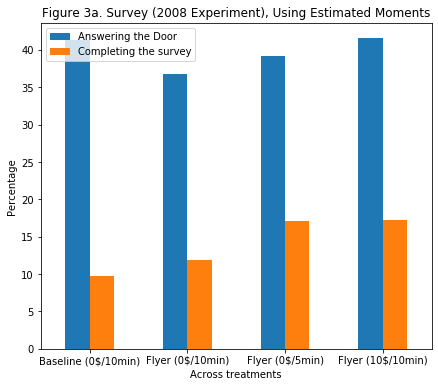

In [237]:
figure6a_regression_estimates()
plt.savefig("figure6a.png")

In [240]:
def figure6b_regression_estimates():
    #df_model = regress_estimates_for_figure4()
    #df_model.reset_index(inplace = True)
    # Plot data for figure 6b
    ans = [df_model[df_model["Variables/Moments"] == 'transNw0d5m'].iloc[0, 1]] + \
          [df_model[df_model["Variables/Moments"] == 'transNw5d5m'].iloc[0, 1]] + \
          [df_model[df_model["Variables/Moments"] == 'transW0d10m09'].iloc[0, 1]] + \
          [df_model[df_model["Variables/Moments"] == 'transW0d5m09'].iloc[0, 1]] + \
          [df_model[df_model["Variables/Moments"] == 'transW5d5m'].iloc[0, 1]] + \
          [df_model[df_model["Variables/Moments"] == 'transW10d5m'].iloc[0, 1]] + \
          [df_model[df_model["Variables/Moments"] == 'transOo0d5m'].iloc[0, 1]] + \
          [df_model[df_model["Variables/Moments"] == 'transOo5d5m'].iloc[0, 1]] 
    
          
    yes = [df_model[df_model["Variables/Moments"] == 'tryesNw0d5m'].iloc[0, 1]] + \
          [df_model[df_model["Variables/Moments"] == 'tryesNw5d5m'].iloc[0, 1]] + \
          [df_model[df_model["Variables/Moments"] == 'tryesW0d10m09'].iloc[0, 1]] + \
          [df_model[df_model["Variables/Moments"] == 'tryesW0d5m09'].iloc[0, 1]] + \
          [df_model[df_model["Variables/Moments"] == 'tryesW5d5m'].iloc[0, 1]] + \
          [df_model[df_model["Variables/Moments"] == 'tryesW10d5m'].iloc[0, 1]] + \
          [df_model[df_model["Variables/Moments"] == 'tryesOo0d5m'].iloc[0, 1]] + \
          [df_model[df_model["Variables/Moments"] == 'tryesOo5d5m'].iloc[0, 1]] 
    
    
    
    
    plotdata = pd.DataFrame(data = {"Answering the Door": list(np.array(ans)*100),
                                   "Completing the survey": list(np.array(yes)*100)},
                           index = ["No flyer (0$/5min)",
                                    "No flyer (5$/5min)",
                                   "Flyer (0$/10min)",
                                   "Flyer (0$/5min)",
                                   "Flyer (5$/5min)",
                                   "Flyer (10$/5min)",
                                   "Opt-out (0$/5min)",
                                   "Opt-out (5$/5min)"])
    plotdata.plot(kind = "bar")
    plt.xticks(rotation=360, horizontalalignment="center")
    plt.title("Figure 3b. Survey (2009 Experiment), Using Estimated Moments")
    plt.xlabel("Across treatments")
    plt.ylabel("Percentage")
    plt.rcParams['figure.figsize'] = [6, 6]
    
    return

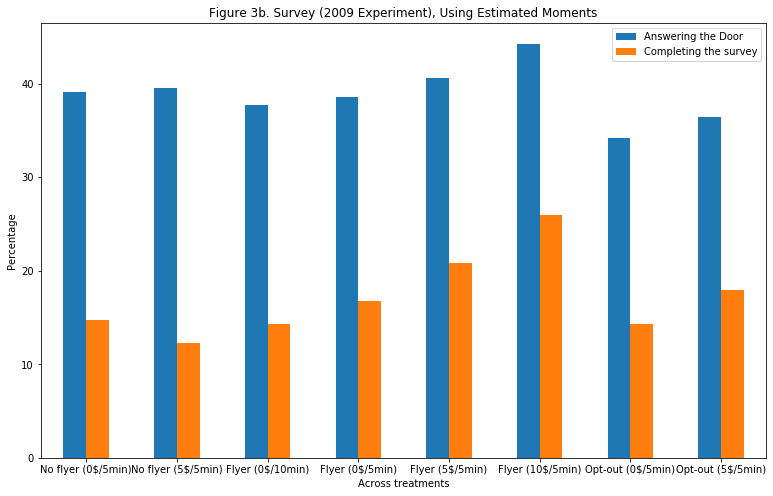

In [241]:
figure6b_regression_estimates()
plt.savefig("figure6b.png")

In [627]:
exp = pd.read_stata(r"C:\Users\Lenovo\Desktop\Master_Thesis\reduced_form\regs\cleanShortQJE_all.dta")

In [630]:
df_paramsc= pd.read_stata(r"C:\Users\Lenovo\Desktop\Master_Thesis\reduced_form\output\moments010_control.dta")